# 驱虫市场的潜力分析

## 分析目的

- 针对各个子类目市场近三年的交易额数据,以及top100品牌数据,通过描述性分析,在年变化的维度上: 
  - 分析整个市场的总体趋势
  - 分析各子类目市场占比及变化趋势
  - 分析市场集中度,即是否存在垄断

## 导入库及读取数据

In [505]:
import numpy as np
import pandas as pd 
import os
import re
import datetime as dt
import time
import seaborn as sns   #画图库
import jieba            #分词需要
import jieba.analyse    # 提取关键字需要

#导入画词云图相关包
import imageio
from wordcloud import WordCloud

In [519]:
import jieba.analyse

- 定位文件位置

In [2]:
os.chdir(r'.\data\电商文本\驱虫剂市场')

- 定义处理数值型日期函数

In [3]:
def get_date(dates):
    if isinstance(dates,pd.Timestamp):
        #new_date=dt.datetime.strftime(dates,'%Y-%m-%d')
        new_date=dates
    else:
        new_date=dt.datetime.strptime('1899-12-30','%Y-%m-%d')+dt.timedelta(days=dates)
        #new_date=dt.datetime.strftime(new_date,'%Y-%m-%d')
    return new_date

- 读取数据

In [4]:
df_data=pd.DataFrame()
for fname in os.listdir():   
    if re.search(r'\.xlsx$',fname):
        col_name=fname.split('.')[0]
        # 读取top100品牌数据
        if 'top100' in col_name:
            top100_data=pd.read_excel(fname)
        # 读取近三年交易数据
        if '近三年交易额' in col_name:            
            col_name=col_name.replace('市场近三年交易额','')
            df=pd.read_excel(fname)
            df['商品类别']=col_name
            df['时间']=df['时间'].apply(get_date) # 统一日期格式
            df_data=pd.concat((df_data,df),ignore_index=True)

- 依时间汇总成各子类目在时间线上的交易金额数据

In [5]:
trade_data=pd.pivot_table(df_data,index='时间',columns='商品类别',
                          values='交易金额',aggfunc='sum',dropna=False).sort_index(ascending=False).reset_index()

In [6]:
trade_data.head()

商品类别,时间,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片
0,2018-10-01,1.136548e+08,106531.29,4171283.35,315639.48,7814546.15,1032414.29,8541153.59
1,2018-09-01,1.440261e+08,105666.63,6784500.17,457366.41,10654973.47,1566651.88,8825870.43
2,2018-08-01,1.540426e+08,201467.03,10709683.41,746513.13,17835577.80,2617149.00,6320153.44
3,2018-07-01,1.480032e+08,438635.29,16589184.89,1871757.00,38877917.83,6209040.06,6302595.06
4,2018-06-01,1.359438e+08,953749.78,23526385.73,3641025.92,76499091.86,12484919.63,7047206.98


In [146]:
trade_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 8 columns):
时间          36 non-null datetime64[ns]
灭鼠杀虫剂       36 non-null float64
电蚊香套装       36 non-null float64
盘香灭蟑香蚊香盘    36 non-null float64
蚊香加热器       36 non-null float64
蚊香液         36 non-null float64
蚊香片         36 non-null float64
防霉防蛀片       36 non-null float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 2.3 KB


## 清洗补全数据

- 由于其中的时间列是从2015年11月到2018年10月,而我们需要的是2016-2018年每月完整的数据(方便从年变化的角度分析产品)
- 这里我们假设：
  - 每年各月之间没有明显规律的周期性变化(近似认为月和月之间的相关性不大)
  - 每年对应月份的数据是线性变化的(一是因为数据少,二是认为随着年份的增长,交易额在大环境下是稳步变化的)
- 故这里我们可以简单的用线性回归预测
  - 即对于每个子类目市场,用15,16,17年的11/12月销售金额预测18年的对应月份

- 定义线性回归函数

In [7]:
def get_LR_result(x,y):
    from sklearn.linear_model import LinearRegression
    lr=LinearRegression().fit(x,y)
    result=lr.predict(pd.DataFrame(np.array([2018])))
    return result

In [8]:
data_11=pd.concat((trade_data[trade_data['时间']=='2015-11-01'],
                  trade_data[trade_data['时间']=='2016-11-01'],
                  trade_data[trade_data['时间']=='2017-11-01']),ignore_index=True)
data_11=data_11.append([{'时间':pd.to_datetime('2018-11-01',format='%Y-%m-%d')}],ignore_index=True)
data_11['年']=data_11['时间'].apply(lambda x:x.year)
cols=data_11.columns.tolist()
for col in cols:
    if col not in ['时间','年']:
        Y=data_11.loc[0:2,col]
        X=pd.DataFrame(data_11.loc[0:2,'年'].values)
        result_1=get_LR_result(X,Y)
        data_11.iloc[-1,cols.index(col)]=result_1  
trade_data=trade_data.append(data_11.iloc[-1,:-1],ignore_index=True)

data_11=pd.concat((trade_data[trade_data['时间']=='2015-12-01'],
                  trade_data[trade_data['时间']=='2016-12-01'],
                  trade_data[trade_data['时间']=='2017-12-01']),ignore_index=True)
data_11=data_11.append([{'时间':pd.to_datetime('2018-12-01',format='%Y-%m-%d')}],ignore_index=True)
data_11['年']=data_11['时间'].apply(lambda x:x.year)
cols=data_11.columns.tolist()
for col in cols:
    if col not in ['时间','年']:
        Y=data_11.loc[0:2,col]
        X=pd.DataFrame(data_11.loc[0:2,'年'].values)
        result_1=get_LR_result(X,Y)
        data_11.iloc[-1,cols.index(col)]=result_1  
trade_data=trade_data.append(data_11.iloc[-1,:-1],ignore_index=True)
trade_data=trade_data.sort_index(ascending=False)

D:\tool\anaconda\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
D:\tool\anaconda\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


## 整体市场分析

- 按照年份查看驱虫市场的总体变化趋势
  - 所有子类目市场每年的交易金额总和;折线图表示变化

In [9]:
trade_data['年']=trade_data['时间'].apply(lambda x:x.year)

In [10]:
year_data=trade_data.groupby(by='年')[['灭鼠杀虫剂','电蚊香套装','盘香灭蟑香蚊香盘',
                                      '蚊香加热器','蚊香液','蚊香片','防霉防蛀片']].sum().reset_index()

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']='Simhei'
plt.rcParams['axes.unicode_minus']=False

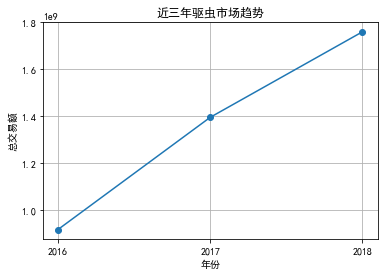

In [12]:
plt.plot(year_data['年'][1:].values,year_data.sum(axis=1)[1:].values,marker='o')
plt.title('近三年驱虫市场趋势')
plt.xlabel('年份')
plt.ylabel('总交易额')
plt.xticks([2016,2017,2018])
plt.grid()

- 可以看出:近三年呈增长趋势,整个市场倾向于成长期和成熟期

## 各市场变化趋势

- 查看各类目市场三年内销售额总和的变化趋势

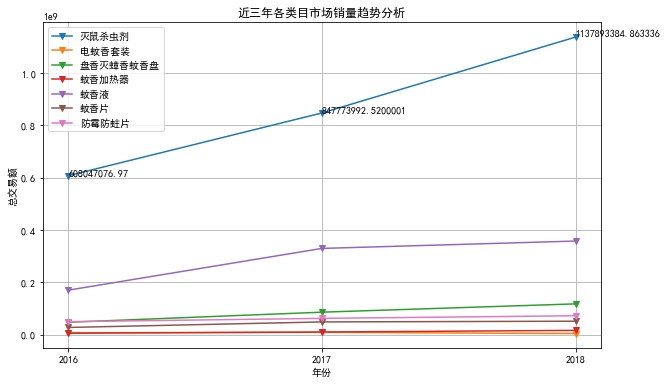

In [293]:
plt.figure(figsize=(10,6))
plt.plot(year_data['年'][1:].values,year_data.iloc[1:,1:],marker='v')
plt.title('近三年各类目市场销量趋势分析')
plt.xlabel('年份')
plt.ylabel('总交易额')
plt.xticks([2016,2017,2018])
plt.text(year_data['年'][1:2].values,year_data.max(axis=1)[1:2],year_data.max(axis=1)[1:2].values[0])
plt.text(year_data['年'][2:3].values,year_data.max(axis=1)[2:3],year_data.max(axis=1)[2:3].values[0])
plt.text(year_data['年'][3:4].values,year_data.max(axis=1)[3:4],year_data.max(axis=1)[3:4].values[0])
plt.grid()
plt.legend(loc=2,labels=year_data.columns.tolist()[1:])

- 直观的看灭鼠杀虫剂和蚊香液都有较大的机会

## 各市场占比

- 查看各类目市场三年内销售额总和的占比

Text(2, 0.4, '64.65%')

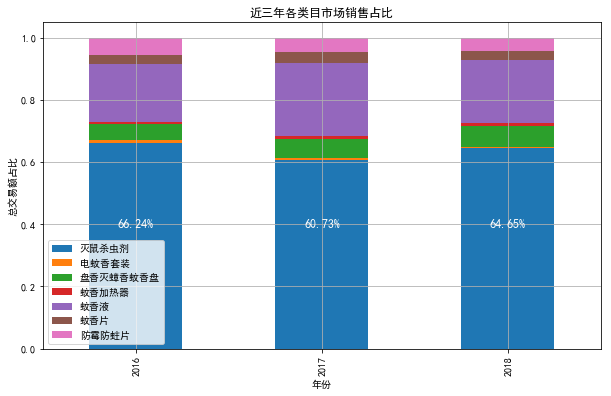

In [401]:
plot_data=year_data.iloc[:,1:].T.apply(lambda x:x/x.sum()).T
plot_data.index=[2015,2016,2017,2018]
fig,ax=plt.subplots(1,1,figsize=(10,6))
plot_data.iloc[1:,:].plot.bar(stacked=True,grid = True,ax=ax)
plt.title('近三年各类目市场销售占比')
plt.xlabel('年份')
plt.ylabel('总交易额占比')
plt.legend(loc=3,labels=plot_data.columns.tolist())
plt.text(0,0.4,'%.2f%%' % (plot_data.iloc[1:,:].max(axis=1).iloc[0]*100),fontsize=12,horizontalalignment='center',
         verticalalignment='center',color='white')
plt.text(1,0.4,'%.2f%%' % (plot_data.iloc[2:,:].max(axis=1).iloc[0]*100),fontsize=12,horizontalalignment='center',
         verticalalignment='center',color='white')
plt.text(2,0.4,'%.2f%%' % (plot_data.iloc[3:,:].max(axis=1).iloc[0]*100),fontsize=12,horizontalalignment='center',
         verticalalignment='center',color='white')

- 可见灭鼠杀虫剂和蚊香液可进一步扩展,就需要与甲方业务人员进一步沟通
- 假设沟通后我们重点关注的是灭鼠杀虫剂

## 各市场年增幅

- 进一步分析各类目市场16-17年17-18年增幅

In [13]:
plot_data=year_data.loc[1:,:].copy()
plot_data=plot_data.iloc[:,1:].T
plot_data.columns=['2016','2017','2018']
plot_data['16-17']=(plot_data['2017']-plot_data['2016'])/plot_data['2016']
plot_data['17-18']=(plot_data['2018']-plot_data['2017'])/plot_data['2017']

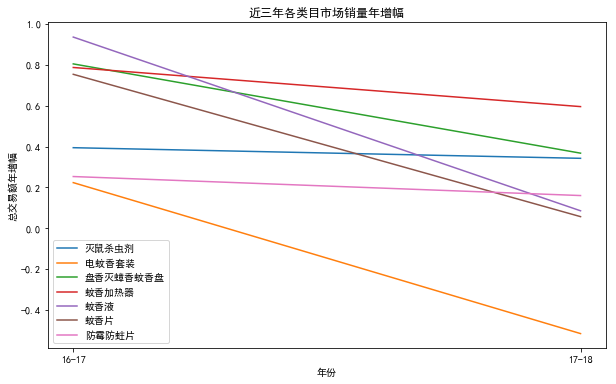

In [442]:
plt.figure(figsize=(10,6))
plt.plot(['16-17','17-18'],plot_data.T.iloc[3:,:])
plt.title('近三年各类目市场销量年增幅')
plt.xlabel('年份')
plt.ylabel('总交易额年增幅')
plt.legend(loc=3,labels=plot_data.T.columns.tolist())

- 可见除了灭鼠杀虫剂和蚊香液增幅比较稳定,其它都有下降甚至变负

## 垄断分析

- 垄断程度,或者说市场势力的重要量化指标是行业集中度
- 常见的指标有行业集中率:CRn指数,赫芬达尔指数(Herfindahl-Hirschman Index,缩写HHI)
- 公式：
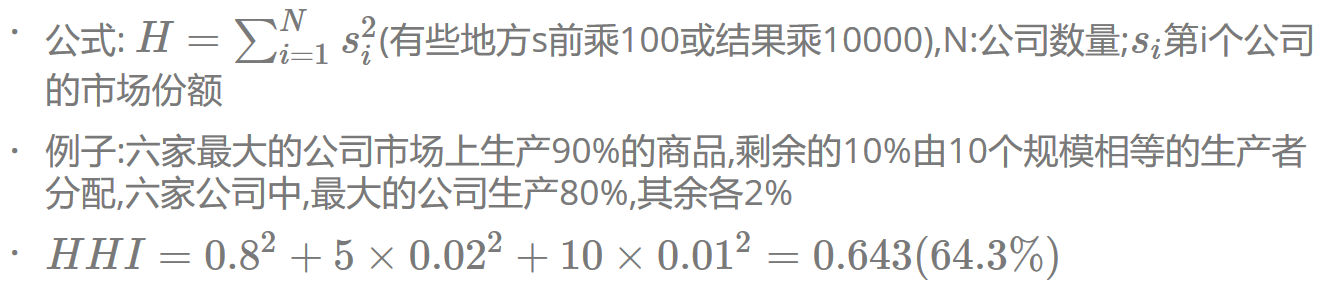
- 指数范围从1/N到1,指数的倒数表示该行业中“等效”的公司数量,上例的市场结构等同于拥有1/0.643=1.55521家相同规模的公司
- HHI的范围说明: [1/N,‘高度竞争行业’,0.01],(0.01,‘不集中的行业’,0.15],(0.15,‘中等集中’,0.25],(0.25,‘高度集中’,1]

### HHI的局限性:
- 行业细分:由于产品分类细化,类间差异大,销售量数据就不一定能准确判断行业集中度.(例如某个大行业中各大公司市场份额相同,但业务不同,仍可能造成垄断)
- 地理范围:从总的市场份额来看占比一致,但是各个公司可能在当地造成垄断
- 长尾现象:无限小众市场抗衡大市场(看具体行业)

### 本项目垄断分析思路
- 使用top100品牌数据,通过交易指数反映销售额从而得到市场占有率,描述各品牌市场份额,计算HHI指标

In [14]:
top100_data['交易指数占比']=top100_data['交易指数']/top100_data['交易指数'].sum()

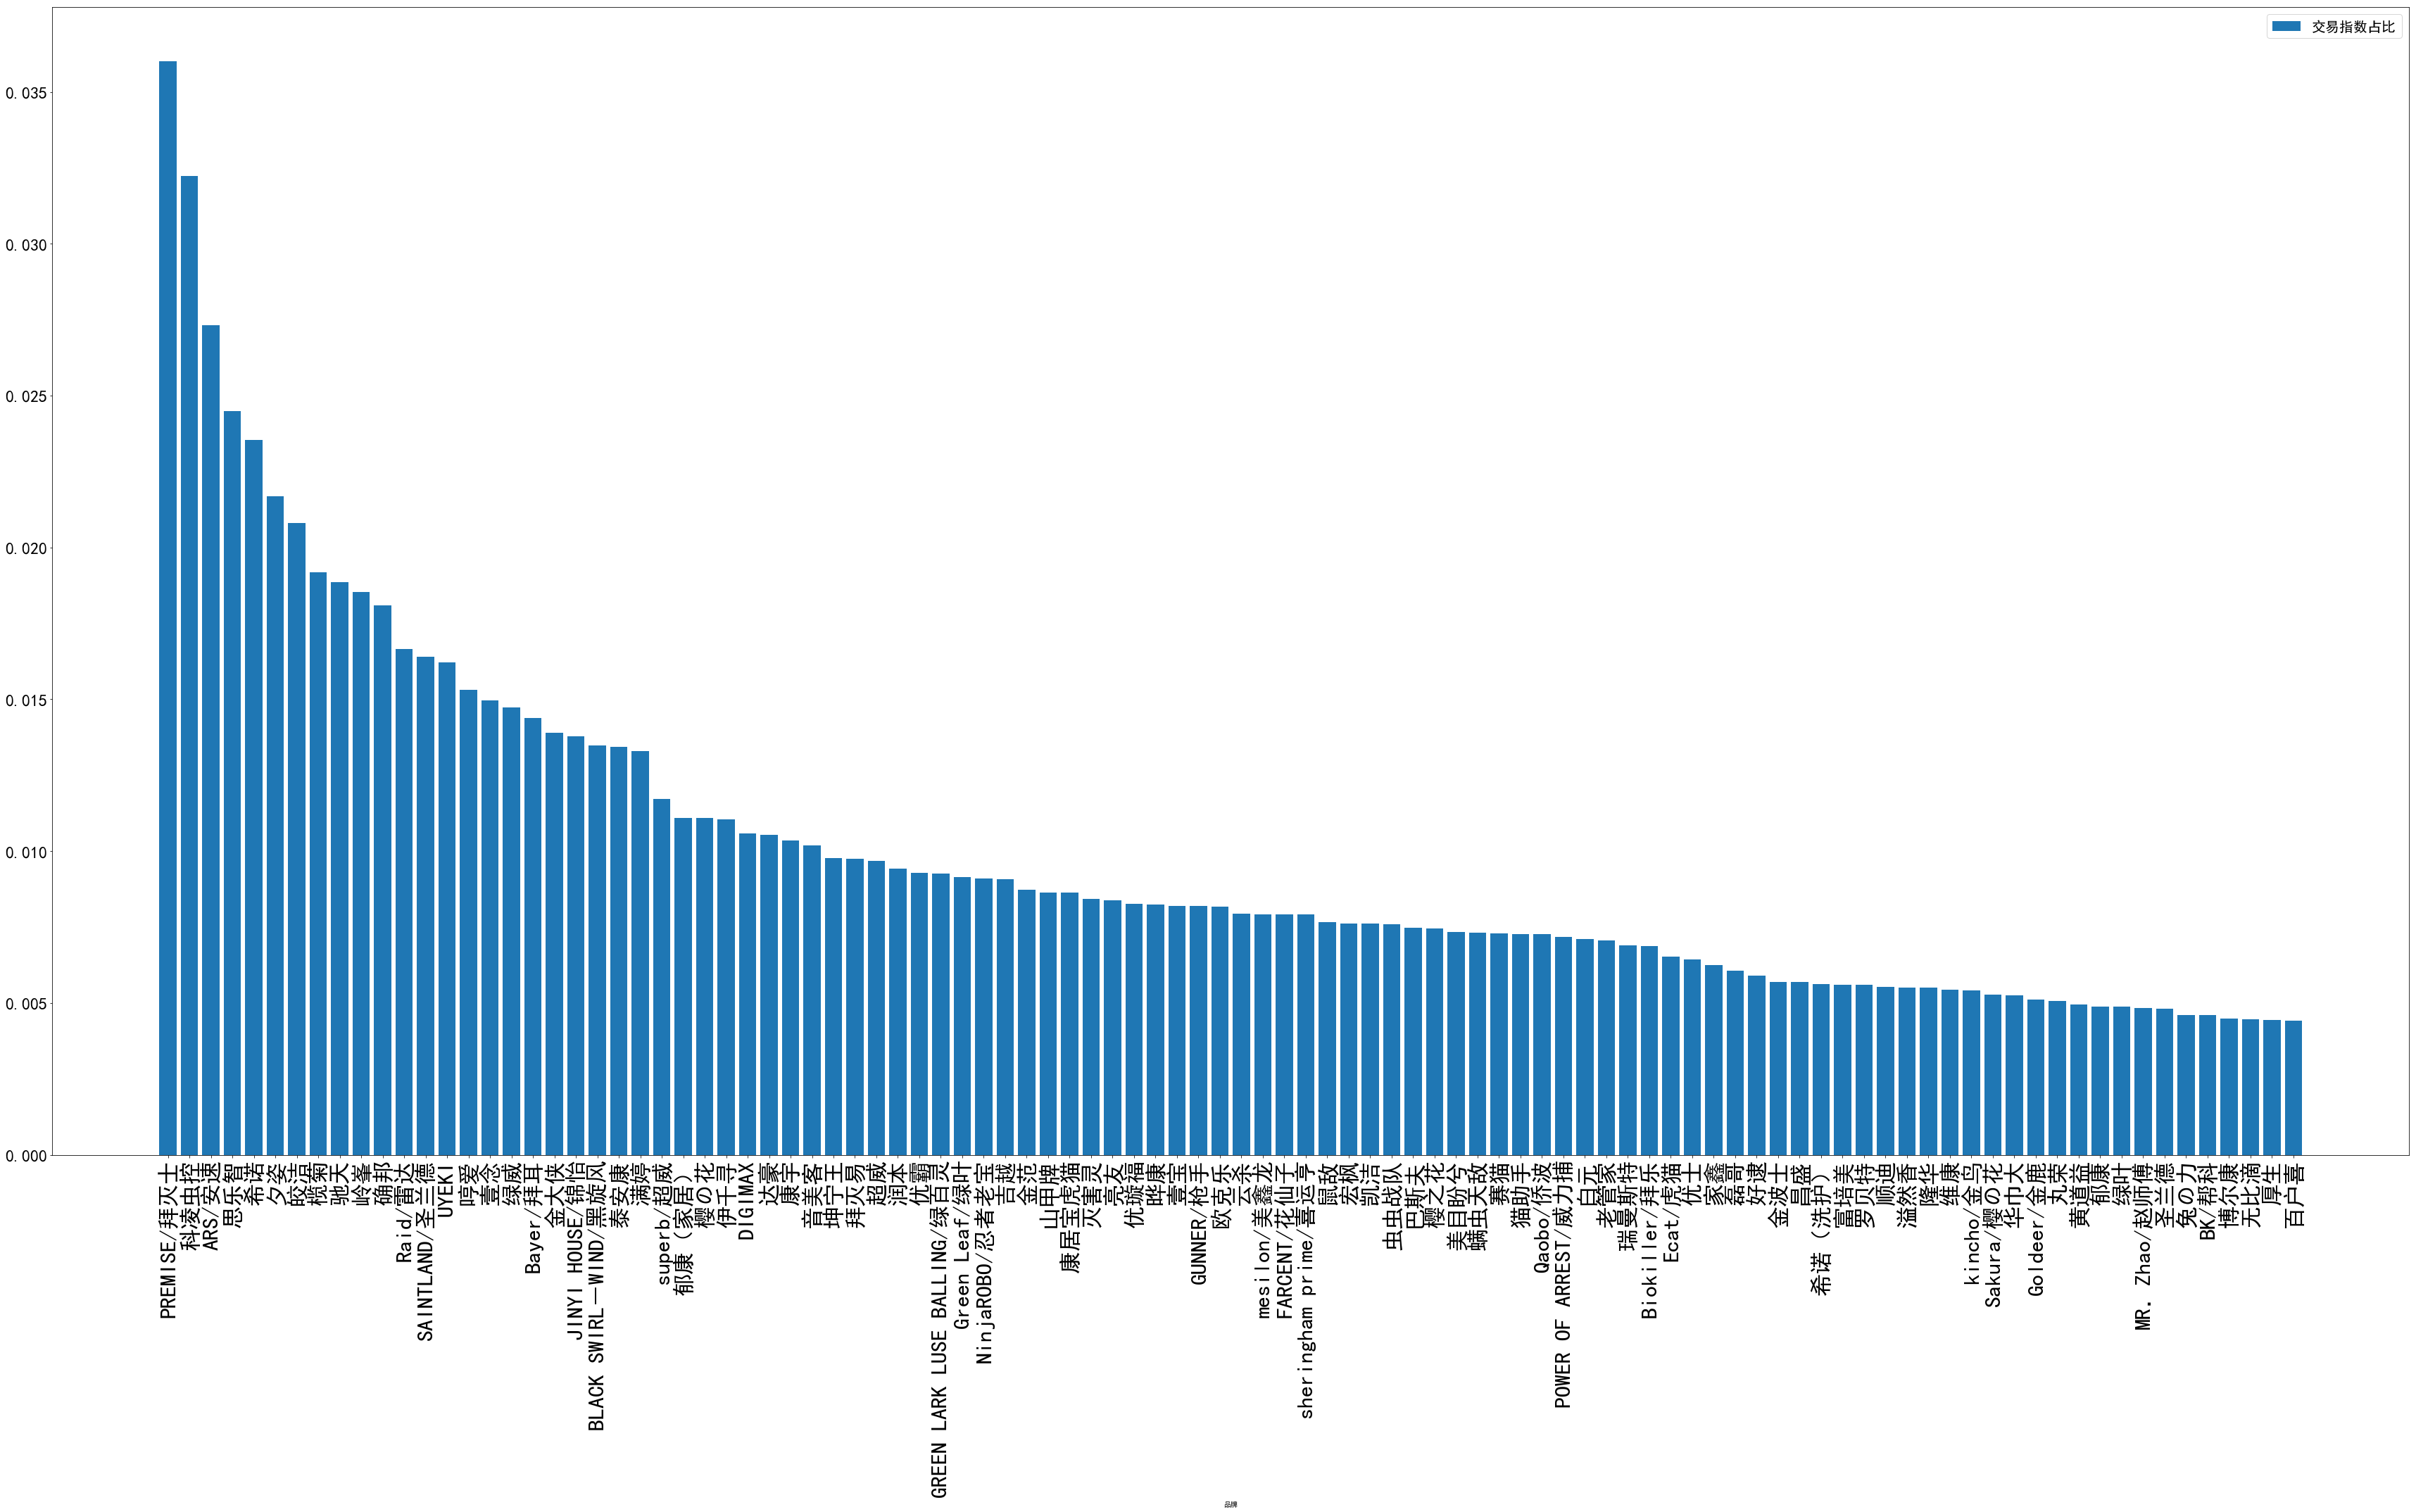

In [499]:
plt.figure(figsize=(60,30))
plt.bar(range(top100_data.shape[0]),top100_data['交易指数占比'],label='交易指数占比')
plt.xlabel('品牌')
plt.xticks(range(top100_data.shape[0]),top100_data['品牌'].tolist(),fontsize=32,rotation=90)
plt.yticks(fontsize=24)
#plt.xlim()
plt.legend(loc=1,fontsize=20)

In [457]:
top100_data.head()

,品牌,行业排名,交易指数,交易增长幅度,支付转化指数,操作
0,PREMISE/拜灭士,1,530344,-0.3235,1521,趋势分析
1,科凌虫控,2,474937,-0.1910,1581,趋势分析
2,ARS/安速,3,402372,-0.2682,1448,趋势分析
3,思乐智,4,360780,0.2056,841,趋势分析
4,希诺,5,346656,-0.1085,1865,趋势分析


In [15]:
HHI=(top100_data['交易指数占比']**2).sum()
HHI

0.013546334007208918

In [16]:
等效公司数=1/HHI
等效公司数

73.82071042009098

- 驱虫市场HHI指数:0.013546(或135.46),等效公司数:73.82

## 结论

- 整体驱虫市场处于快速增长阶段,趋向于成长期到成熟期
- 灭鼠杀虫剂市场份额较大(大于60%),约是第二名蚊香液的二倍,市场增长率接近40%,可以认为是明星产品类目,需要持续投资和重点关注
- 驱虫市场不存在垄断,结构不集中,竞争相对激烈,即没有明显的来自大公司的压力

# 灭鼠杀虫剂市场机会点分析

## 业务逻辑

- 子类目市场确定后(灭鼠杀虫剂市场):确定市场中最受欢迎的产品类别–>细分价格段–>属性进一步分析:什么样的价格作为主市场,什么样的商品符合大众口味
- 不同用途的商品定位: 
  - 引流商品:价格低,利润空间几乎没有,目的是为了引流
    - 获取流量的方式有免费和付费两种,免费流量看缘分(lian),控制付费流量成本即是对流量精准度的要求,即精准营销
  - 利润商品:价格合理,只要的盈利来源
  - 品牌商品:价格偏高,门面商品或奢侈品
- 商品布局时要考虑的问题:价格,产品特征,用户喜好度,商品需求等

## 产品类别分析

- 定位文件位置

In [18]:
os.chdir(r'..')#返回上一级目录，若需要返回前两级目录，此命令执行两次

In [22]:
os.getcwd()

'E:\\Data analysis\\CDA\\learning\\0、python自己练习\\7、项目实战\\data\\电商文本\\灭鼠杀虫剂细分市场'

In [19]:
os.chdir(r'.\灭鼠杀虫剂细分市场') 

FileNotFoundError: [WinError 2] 系统找不到指定的文件。: '.\\灭鼠杀虫剂细分市场'

### 读取数据

In [23]:
mssc_data=pd.DataFrame()
for fname in os.listdir():   
    if re.search(r'\.xlsx$',fname):
        # 读取数据
        df=pd.read_excel(fname,date_parser=['时间','下架时间']) 
        mssc_data=pd.concat((mssc_data,df),ignore_index=True)

D:\tool\anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [24]:
pd.set_option('display.max_columns',300) #显示全部列

In [548]:
mssc_data.isna().mean()

 型号            1.000000
18年全码          0.999695
250毫升          0.999847
3C产品型号         1.000000
3C规格型号         0.999237
800g/袋         0.999847
CCC证书编号        1.000000
DSR_描述分        1.000000
DSR_描述行业对比     1.000000
DSR_服务分        1.000000
DSR_服务行业对比     1.000000
DSR_物流分        1.000000
DSR_物流行业对比     1.000000
Unnamed: 33    1.000000
Unnamed: 34    1.000000
Unnamed: 40    1.000000
Unnamed: 67    1.000000
三个装            1.000000
上市时间           1.000000
下架时间           0.000000
主图视频链接         0.746797
主图链接           0.000000
产品             1.000000
产品PH值          1.000000
产品剂型           1.000000
产品名            1.000000
产品名称           0.796980
产品尺寸           1.000000
产品材质           1.000000
产品特点           0.999847
                 ...   
输出电流           1.000000
运费             0.000000
适合肤质           1.000000
适用作物           0.999847
适用对象           0.279896
适用尺码           1.000000
适用空间           1.000000
适用范围           0.999847
适用面积           1.000000
配件类型           1.000000
采购地            1

### 清洗数据

- 去掉大量缺失值的列,去掉单一值的列,
- 去掉逻辑上不可用的列,如:‘时间’,‘链接’,‘主图链接’,‘主图视频链接’,‘页码’,‘排名’,‘宝贝标题’,‘运费’,‘下架时间’,‘旺旺’

In [25]:
mssc_data_copy=mssc_data.copy() #清洗数据前复制数据

In [38]:
for col in mssc_data.columns:
    if mssc_data[col].isna().mean()>=0.98:
        del mssc_data[col]                   
    # 去掉全是缺失值的列
    
for col in mssc_data.columns:
    if mssc_data[col].unique().shape[0]==1:
        del mssc_data[col]                   
    # 去掉单一值的列 

mssc_data.columns=mssc_data.columns.map(lambda x:x.strip()) #去除列名中的空格

In [40]:
# 去掉逻辑上不可用的列
for col in ['时间','链接','主图链接','主图视频链接','页码','排名','宝贝标题','运费','下架时间','旺旺']:
    del mssc_data[col]

### 查看各产品’类别’总的’预估销售额’的分布

In [41]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']='Simhei'
plt.rcParams['axes.unicode_minus']=False

In [42]:
sale_sumd=mssc_data[['类别','预估销售额']].groupby(by='类别').sum()
sale_sumd['预估销售额占比']=sale_sumd['预估销售额']*100/sale_sumd['预估销售额'].sum()

Text(0, 0.5, '预估销售额')

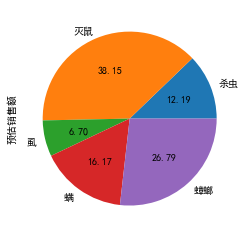

In [43]:
plt.pie(sale_sumd['预估销售额占比'],labels=sale_sumd.index.tolist(),autopct='%.2f')
plt.ylabel('预估销售额')

- 可以看出重点需要研究的市场是灭鼠和蟑螂,这里我们选择灭鼠

## 灭鼠类别分析

- 选择灭鼠数据进一步分析–>依据’售价’进行价格划分,得到若干的价格区间
- 每个价格区间计算:预估销售额(总和),销售额占比,宝贝数(不同’宝贝ID’数),宝贝数占比,单宝贝平均销售额(不同宝贝的平均预估销售额,可以理解为竞争的反面,单宝贝平均销售额越高,竞争越低,单宝贝销售额高才有的分),相对竞争度(由前一项套入线性变换s=1−(d−mind)/(maxd−mind)得到,0表示类目中最小竞争,1表示最大)

- 先获取灭鼠类别数据

In [44]:
rats_data=mssc_data[mssc_data['类别']=='灭鼠'].copy()
rats_data['价格区间']=pd.cut(rats_data['售价'],bins=[0,50,100,150,200,250,300,np.inf],
       labels=['0_50','50_100','100_150','150_200','200_250','250_300','300以上'])
rats_data['销售额占比']=rats_data['预估销售额']/rats_data['预估销售额'].sum()

- 对灭鼠数据按价格区间进行汇总处理

In [680]:
price_data=rats_data[['价格区间','预估销售额','销售额占比']].groupby(by='价格区间').sum()
price_data=pd.concat((price_data,
           rats_data[['价格区间','宝贝ID']].drop_duplicates().groupby(by='价格区间').count()),
          axis=1)
price_data.rename(columns={'宝贝ID':'宝贝数'},inplace=True)
price_data['宝贝数占比']=price_data['宝贝数']/price_data['宝贝数'].sum()
price_data['单宝贝平均销售额']=price_data['预估销售额']/price_data['宝贝数']

- 计算相对竞争度

In [696]:
price_data['相对竞争度']=1-(price_data['单宝贝平均销售额']-
 price_data['单宝贝平均销售额'].min())/(price_data['单宝贝平均销售额'].max()-
                                price_data['单宝贝平均销售额'].min())
price_data.sort_values(by='相对竞争度',inplace=True)
price_data

,预估销售额,销售额占比,宝贝数,宝贝数占比,单宝贝平均销售额,相对竞争度
价格区间,,,,,,
200_250,2743758.00,0.106819,7,0.006173,391965.428571,0.000000
100_150,2758086.29,0.107377,46,0.040564,59958.397609,0.887218
300以上,819468.00,0.031903,18,0.015873,45526.000000,0.925786
250_300,237740.00,0.009256,9,0.007937,26415.555556,0.976854
150_200,629813.00,0.024520,28,0.024691,22493.321429,0.987336
50_100,3335060.19,0.129840,172,0.151675,19389.884826,0.995629
0_50,15162086.51,0.590286,854,0.753086,17754.199660,1.000000


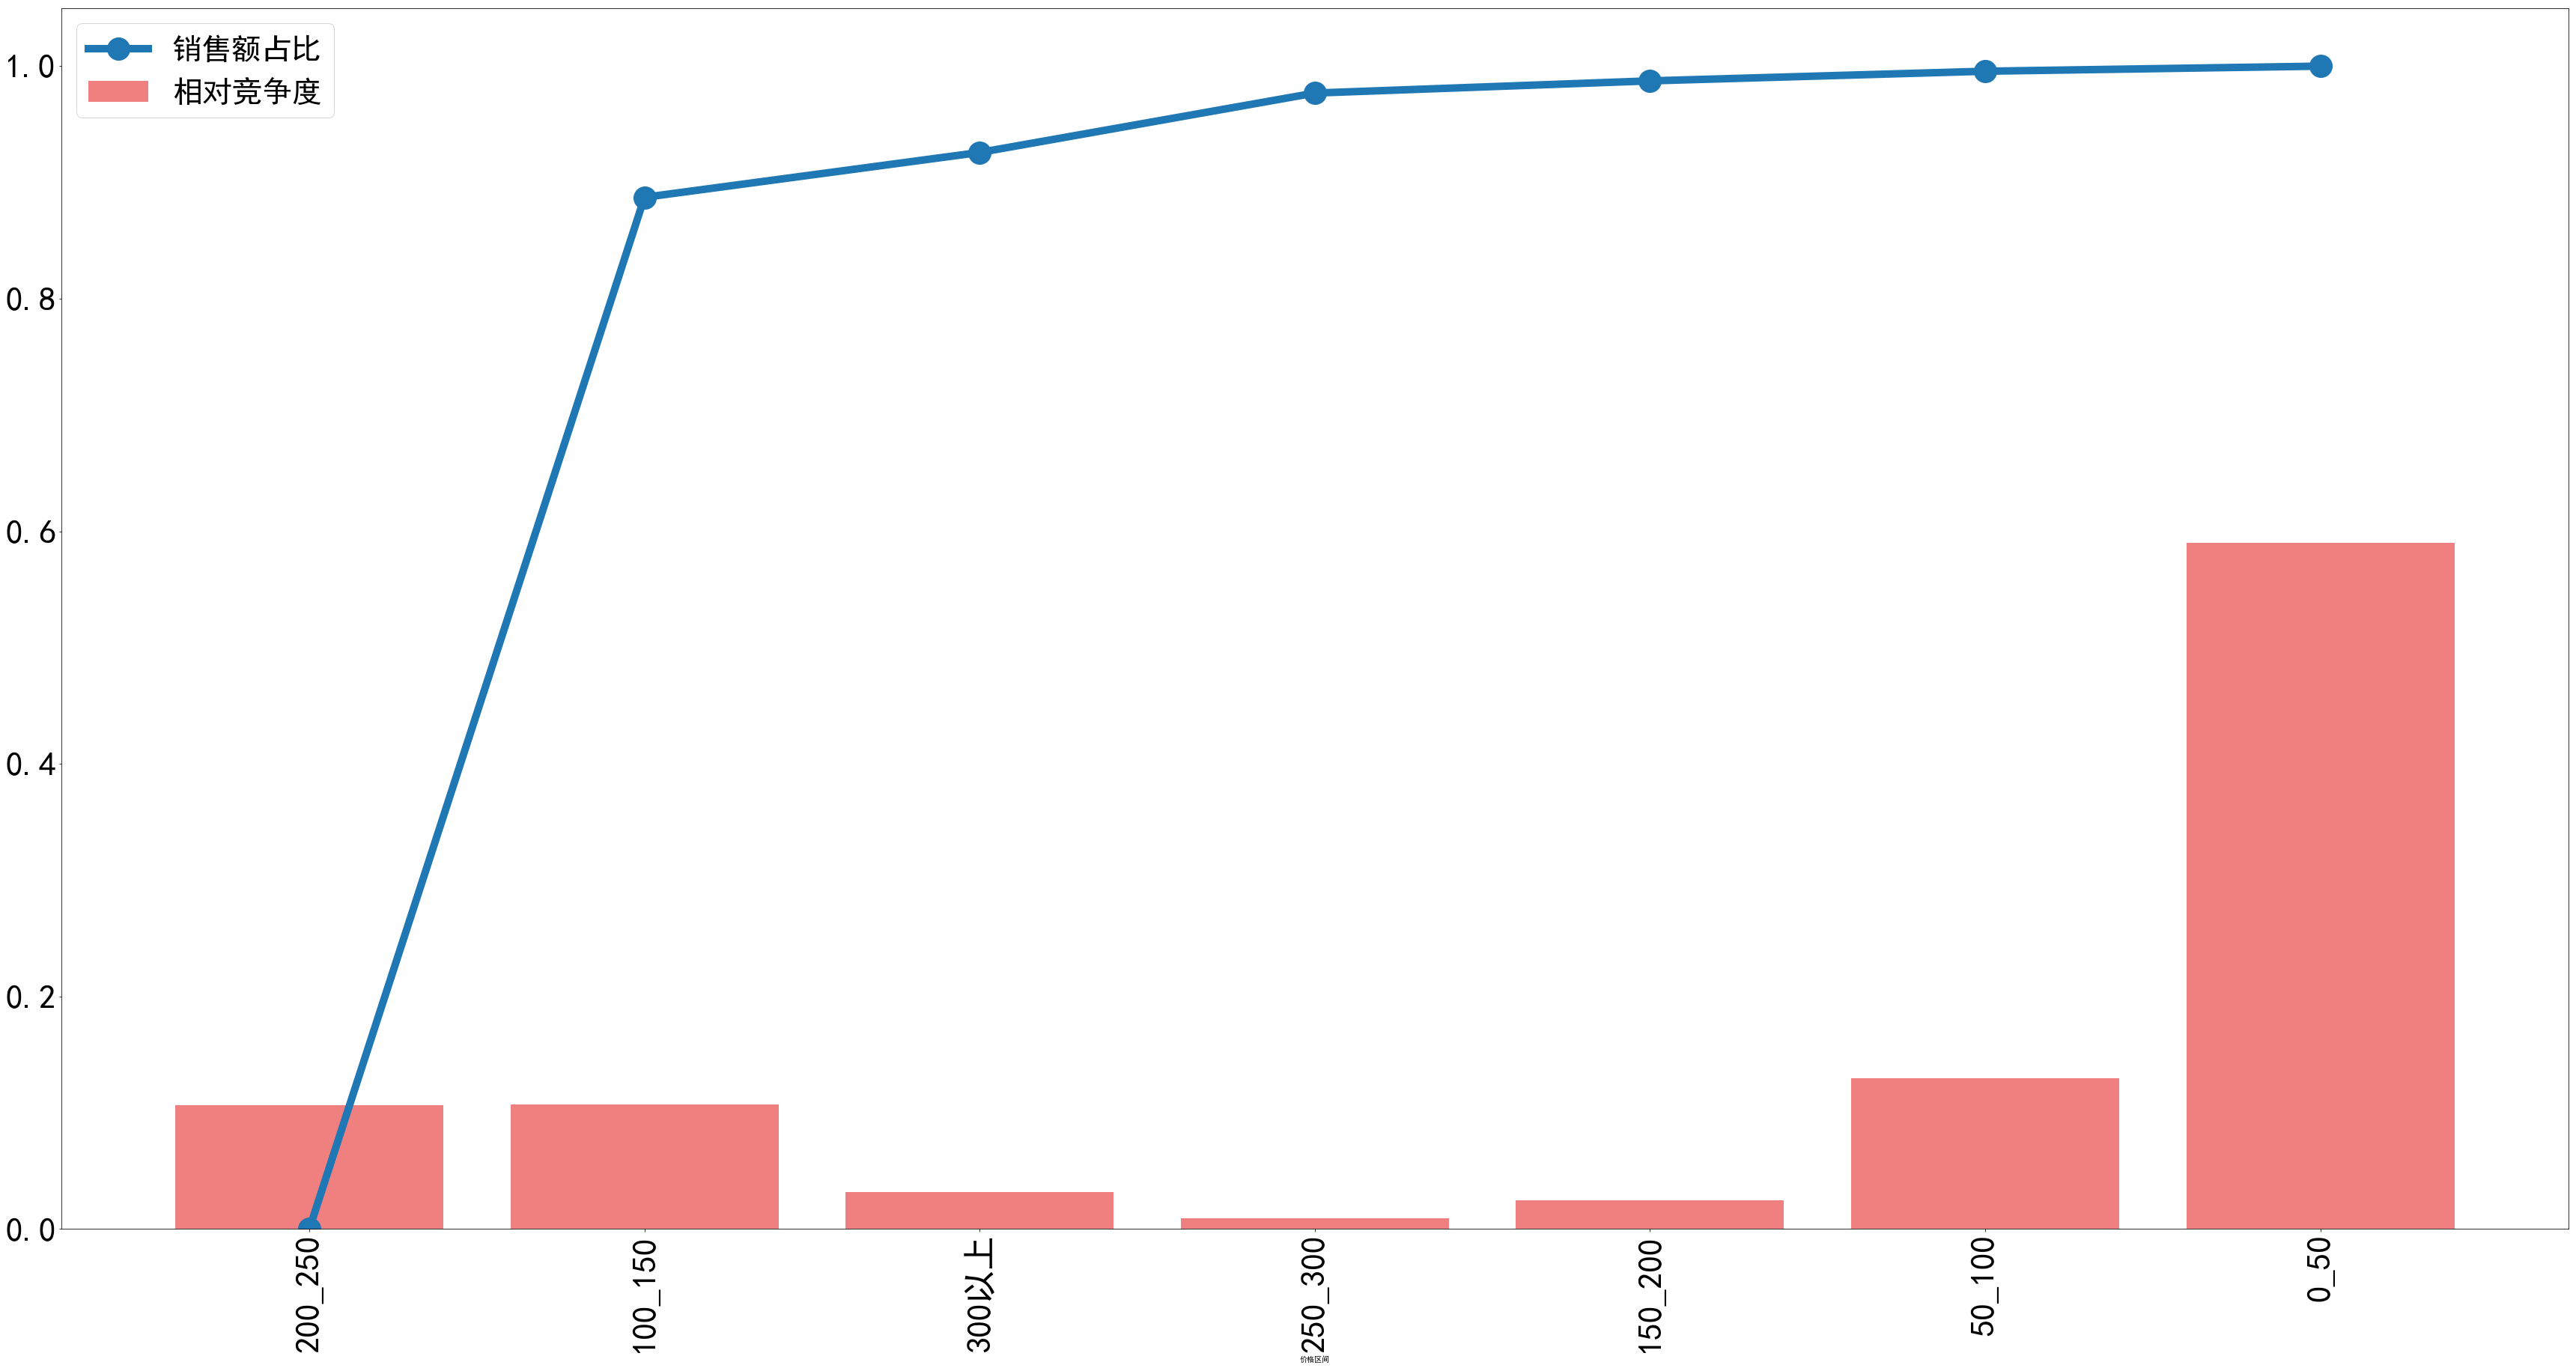

In [716]:
plt.figure(figsize=(60,30))
plt.bar(range(price_data.shape[0]),price_data['销售额占比'],color='lightcoral')
plt.plot(range(price_data.shape[0]),price_data['相对竞争度'],
         marker='o',linewidth=10,markersize=30)
plt.xlabel('价格区间')
plt.xticks(range(price_data.shape[0]),price_data.index.tolist(),fontsize=45,rotation=90)
plt.yticks(fontsize=45)
#plt.xlim()
plt.legend(loc=2,fontsize=40,labels=['销售额占比','相对竞争度'])

- 可见0-50容量大,竞争大,大容量市场(对比的是50-100,容量小,竞争稍小)
    - 200-250,竞争小,做高价市场的优先选择,属于机会点
- 可见我们喜欢的类目是:市场份额高(表示更适合大众),相对竞争度低(没人抢).也就是找到闷声发大财的那些个分类去分蛋糕

## 0_50细分价格市场分析

- 再一次细分得到新的更小的价格区间,计算每个区间的指标

In [724]:
price50_data1=rats_data[rats_data['售价']<=50].copy()

In [725]:
price50_data1['价格区间']=pd.cut(price50_data1['售价'],bins=[0,10,20,30,40,50],
       labels=['0_10','10_20','20_30','30_40','40_50'])
price50_data1['销售额占比']=price50_data1['预估销售额']/price50_data1['预估销售额'].sum()

In [726]:
price50_data=price50_data1[['价格区间','预估销售额','销售额占比']].groupby(by='价格区间').sum()
price50_data=pd.concat((price50_data,
           price50_data1[['价格区间','宝贝ID']].drop_duplicates().groupby(by='价格区间').count()),
          axis=1)
price50_data.rename(columns={'宝贝ID':'宝贝数'},inplace=True)
price50_data['宝贝数占比']=price50_data['宝贝数']/price50_data['宝贝数'].sum()
price50_data['单宝贝平均销售额']=price50_data['预估销售额']/price50_data['宝贝数']

In [728]:
price50_data['相对竞争度']=1-(price50_data['单宝贝平均销售额']-
 price50_data['单宝贝平均销售额'].min())/(price50_data['单宝贝平均销售额'].max()-
                                price50_data['单宝贝平均销售额'].min())
price50_data.sort_values(by='相对竞争度',inplace=True)
price50_data

,预估销售额,销售额占比,宝贝数,宝贝数占比,单宝贝平均销售额,相对竞争度
价格区间,,,,,,
10_20,8102634.14,0.534401,272,0.318501,29789.096103,0.000000
20_30,4969620.92,0.327766,278,0.325527,17876.334245,0.411674
40_50,707568.49,0.046667,40,0.046838,17689.212250,0.418141
30_40,1240874.19,0.081841,98,0.114754,12661.981531,0.591869
0_10,141388.77,0.009325,166,0.194379,851.739578,1.000000


- 画分布图

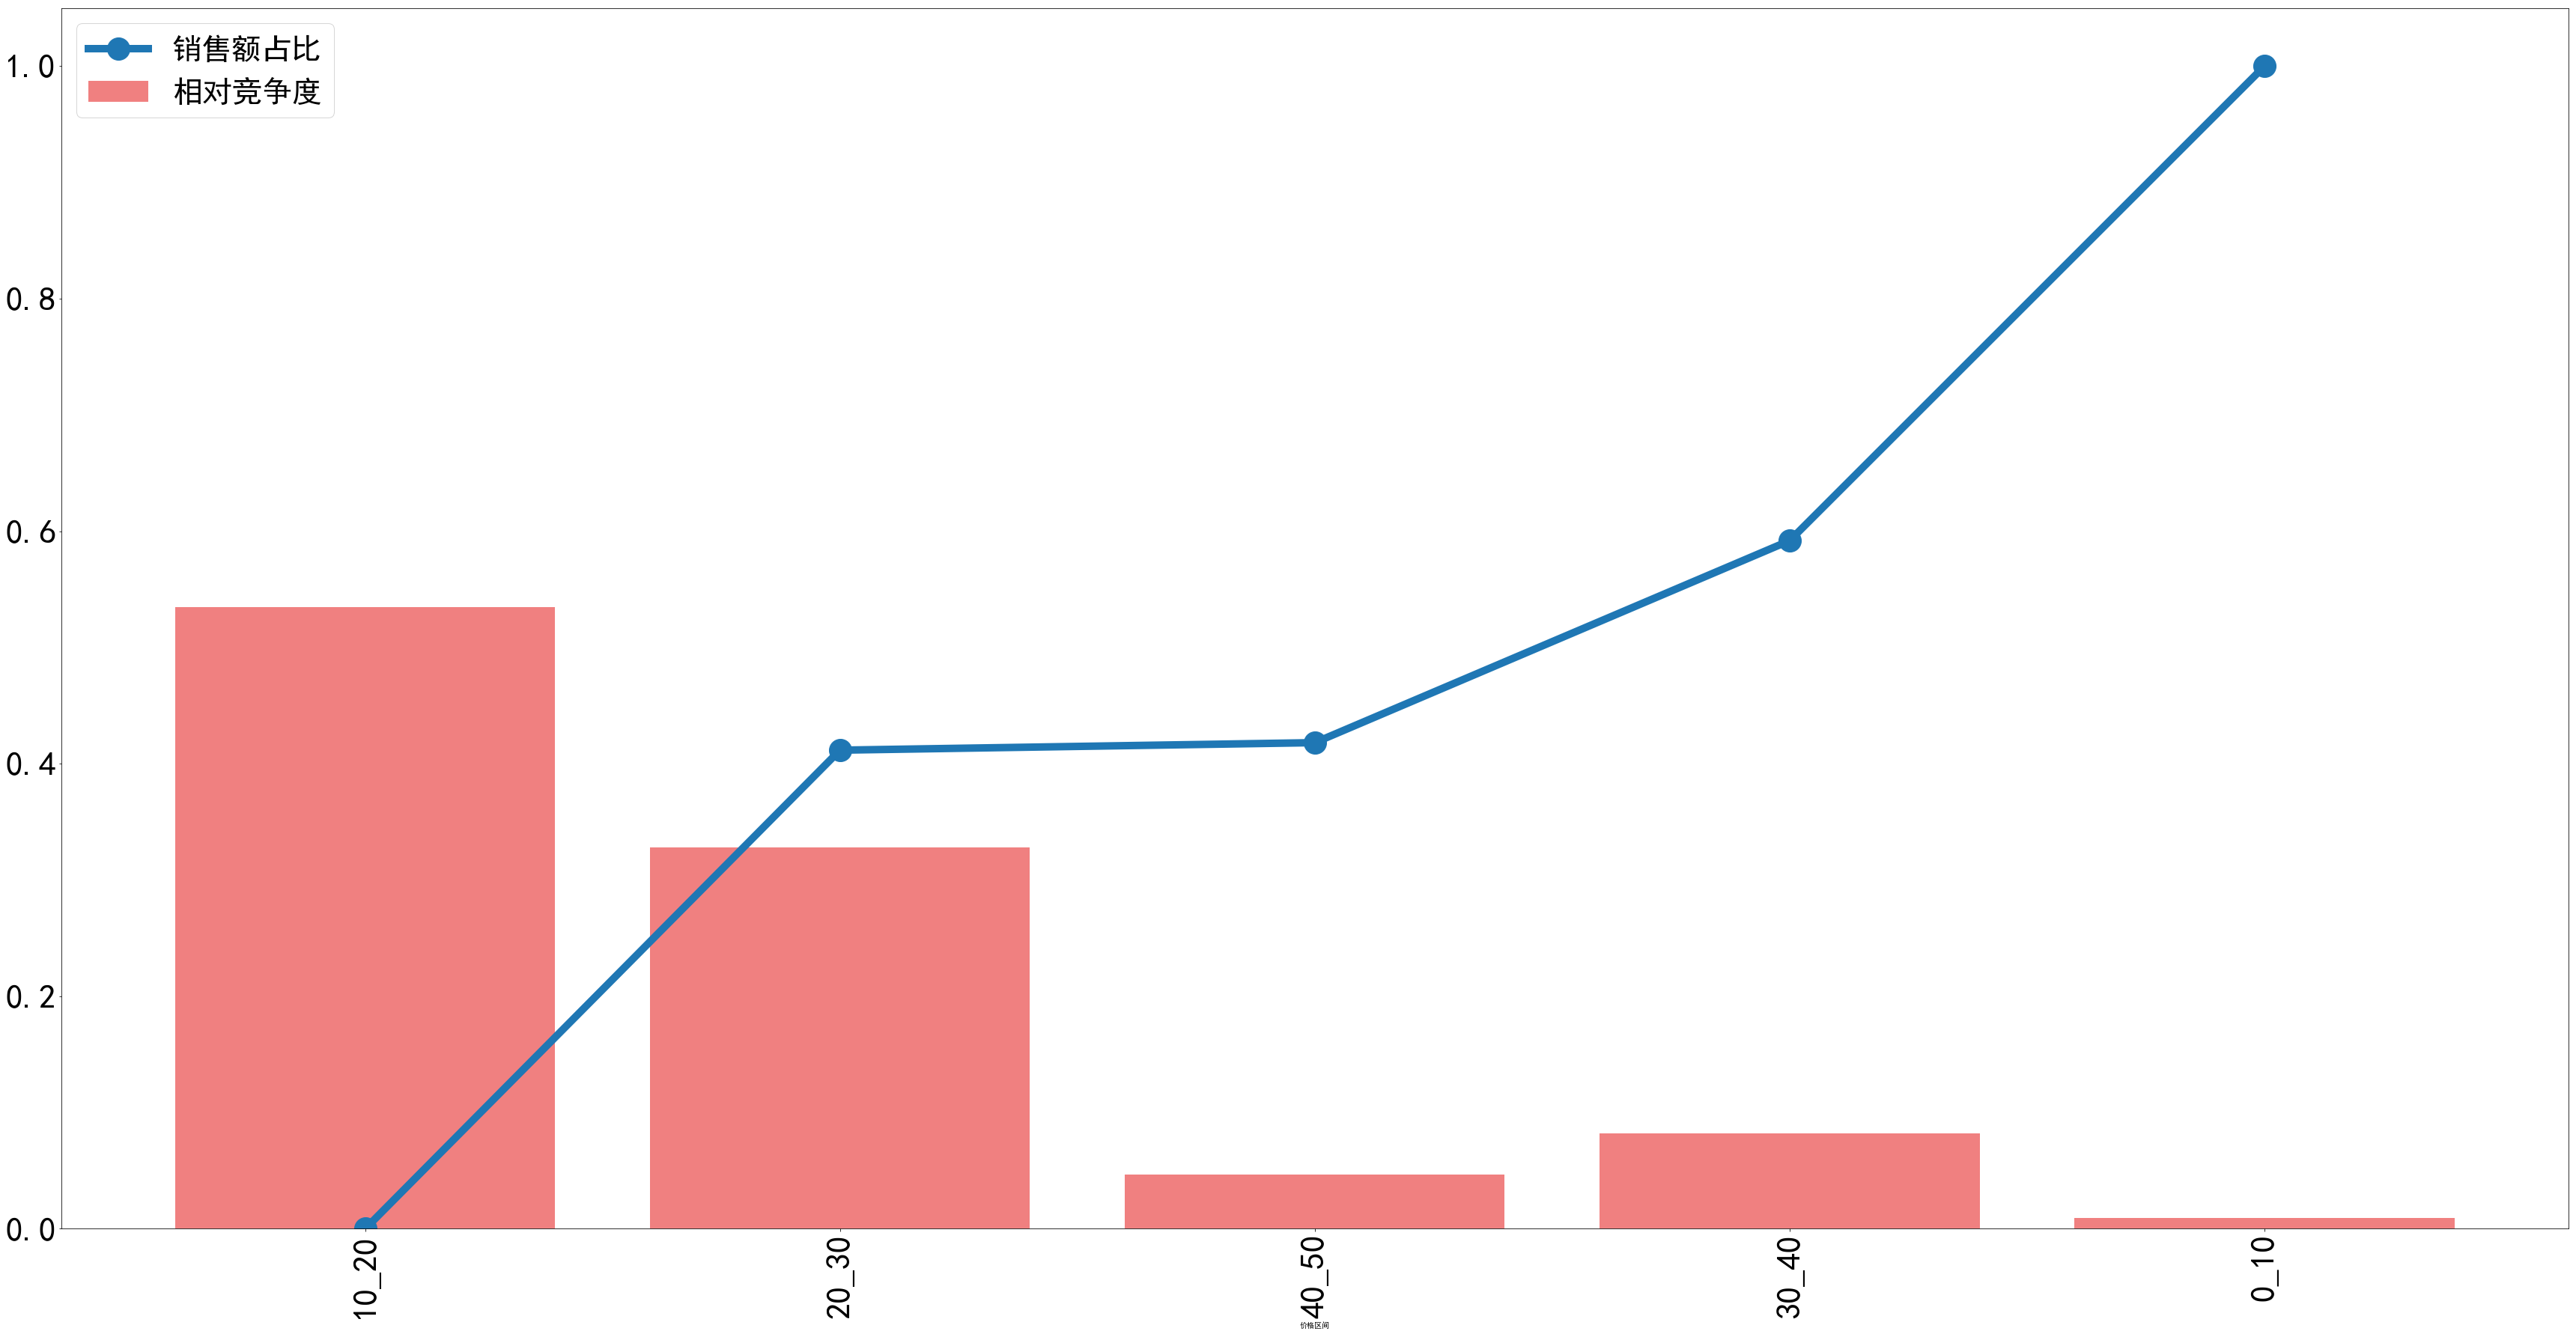

In [729]:
plt.figure(figsize=(60,30))
plt.bar(range(price50_data.shape[0]),price50_data['销售额占比'],color='lightcoral')
plt.plot(range(price50_data.shape[0]),price50_data['相对竞争度'],
         marker='o',linewidth=10,markersize=30)
plt.xlabel('价格区间')
plt.xticks(range(price50_data.shape[0]),price50_data.index.tolist(),
           fontsize=45,rotation=90)
plt.yticks(fontsize=45)
#plt.xlim()
plt.legend(loc=2,fontsize=40,labels=['销售额占比','相对竞争度'])

- 可见10-20竞争度低,容量大,优选,20-30也不错
- 200-250细分市场也是同样的分析思路

## 其他属性分析

### 店铺类型分析

In [735]:
#按店铺类型汇总数据
shop_data=rats_data[['店铺类型','预估销售额','销售额占比']].groupby(by='店铺类型').sum()
#计算不同宝贝数
shop_data=pd.concat((shop_data,
           rats_data[['店铺类型','宝贝ID']].drop_duplicates().groupby(by='店铺类型').count()),
          axis=1)
shop_data.rename(columns={'宝贝ID':'宝贝数'},inplace=True)
#计算宝贝数占比
shop_data['宝贝数占比']=shop_data['宝贝数']/shop_data['宝贝数'].sum()
# 计算相对竞争度
shop_data['单宝贝平均销售额']=shop_data['预估销售额']/shop_data['宝贝数']
shop_data['相对竞争度']=1-(shop_data['单宝贝平均销售额']-
 shop_data['单宝贝平均销售额'].min())/(shop_data['单宝贝平均销售额'].max()-
                                shop_data['单宝贝平均销售额'].min())
shop_data.sort_values(by='相对竞争度',inplace=True)
shop_data

,预估销售额,销售额占比,宝贝数,宝贝数占比,单宝贝平均销售额,相对竞争度
店铺类型,,,,,,
天猫,23551572.38,0.916903,345,0.304233,68265.427188,0.0
淘宝,2134439.61,0.083097,789,0.695767,2705.246654,1.0


- 画分布图

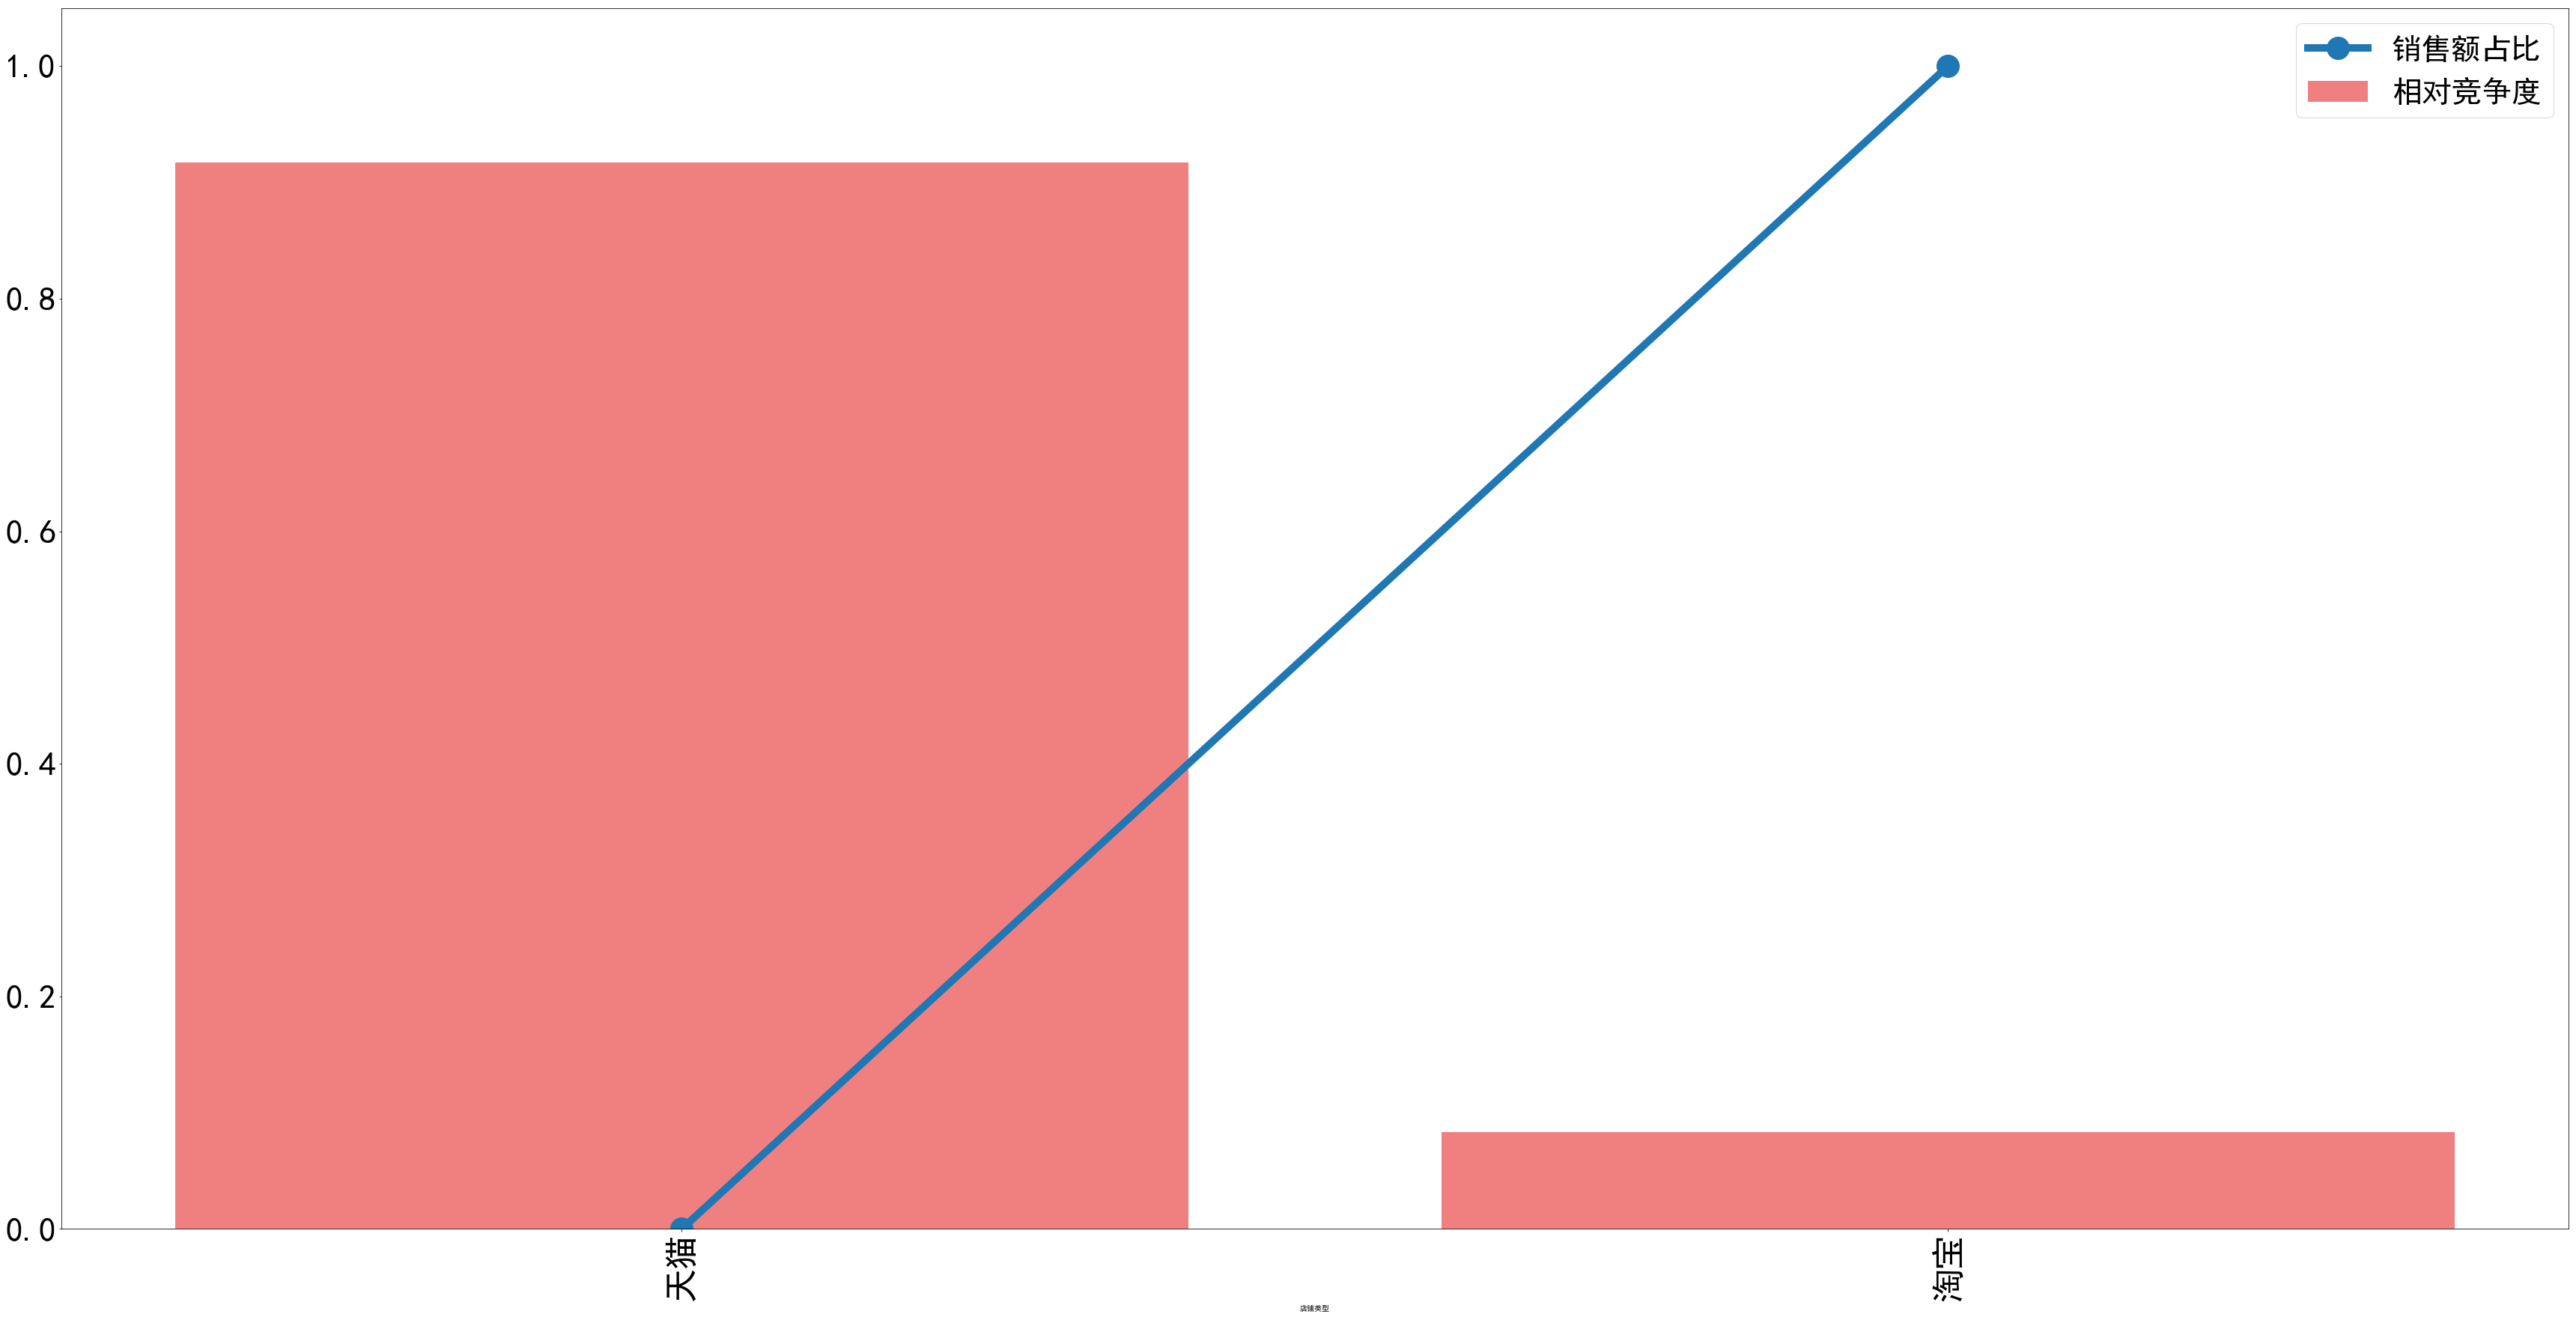

In [738]:
plt.figure(figsize=(60,30))
plt.bar(range(shop_data.shape[0]),shop_data['销售额占比'],color='lightcoral')
plt.plot(range(shop_data.shape[0]),shop_data['相对竞争度'],
         marker='o',linewidth=10,markersize=30)
plt.xlabel('店铺类型')
plt.xticks(range(shop_data.shape[0]),shop_data.index.tolist(),
           fontsize=45,rotation=90)
plt.yticks(fontsize=45)
#plt.xlim()
plt.legend(loc=1,fontsize=40,labels=['销售额占比','相对竞争度'])

- 可见天猫各个方面都优于淘宝

### 型号分析

In [762]:
#按型号汇总数据
tempdata=rats_data[rats_data['型号'].notnull()].copy()
model_data=tempdata[['型号','预估销售额','销售额占比']].groupby(by='型号').sum()
#计算不同宝贝数
model_data=pd.concat((model_data,
           tempdata[['型号','宝贝ID']].drop_duplicates().groupby(by='型号').count()),
          axis=1)
model_data.rename(columns={'宝贝ID':'宝贝数'},inplace=True)
#计算宝贝数占比
model_data['宝贝数占比']=model_data['宝贝数']/model_data['宝贝数'].sum()
# 计算相对竞争度
model_data['单宝贝平均销售额']=model_data['预估销售额']/model_data['宝贝数']
model_data['相对竞争度']=1-(model_data['单宝贝平均销售额']-
 model_data['单宝贝平均销售额'].min())/(model_data['单宝贝平均销售额'].max()-
                                model_data['单宝贝平均销售额'].min())
model_data.sort_values(by='销售额占比',ascending=False,inplace=True)
model_data.head()

,预估销售额,销售额占比,宝贝数,宝贝数占比,单宝贝平均销售额,相对竞争度
型号,,,,,,
SK600,2672898.00,0.104060,1,0.001361,2.672898e+06,0.000000
超强力粘鼠板,2120129.32,0.082540,12,0.016327,1.766774e+05,0.933900
粘鼠板老鼠贴,2051699.02,0.079876,7,0.009524,2.930999e+05,0.890344
JF-807,1121452.00,0.043660,1,0.001361,1.121452e+06,0.580436
0005,927590.70,0.036113,2,0.002721,4.637953e+05,0.826482


- 画分布图

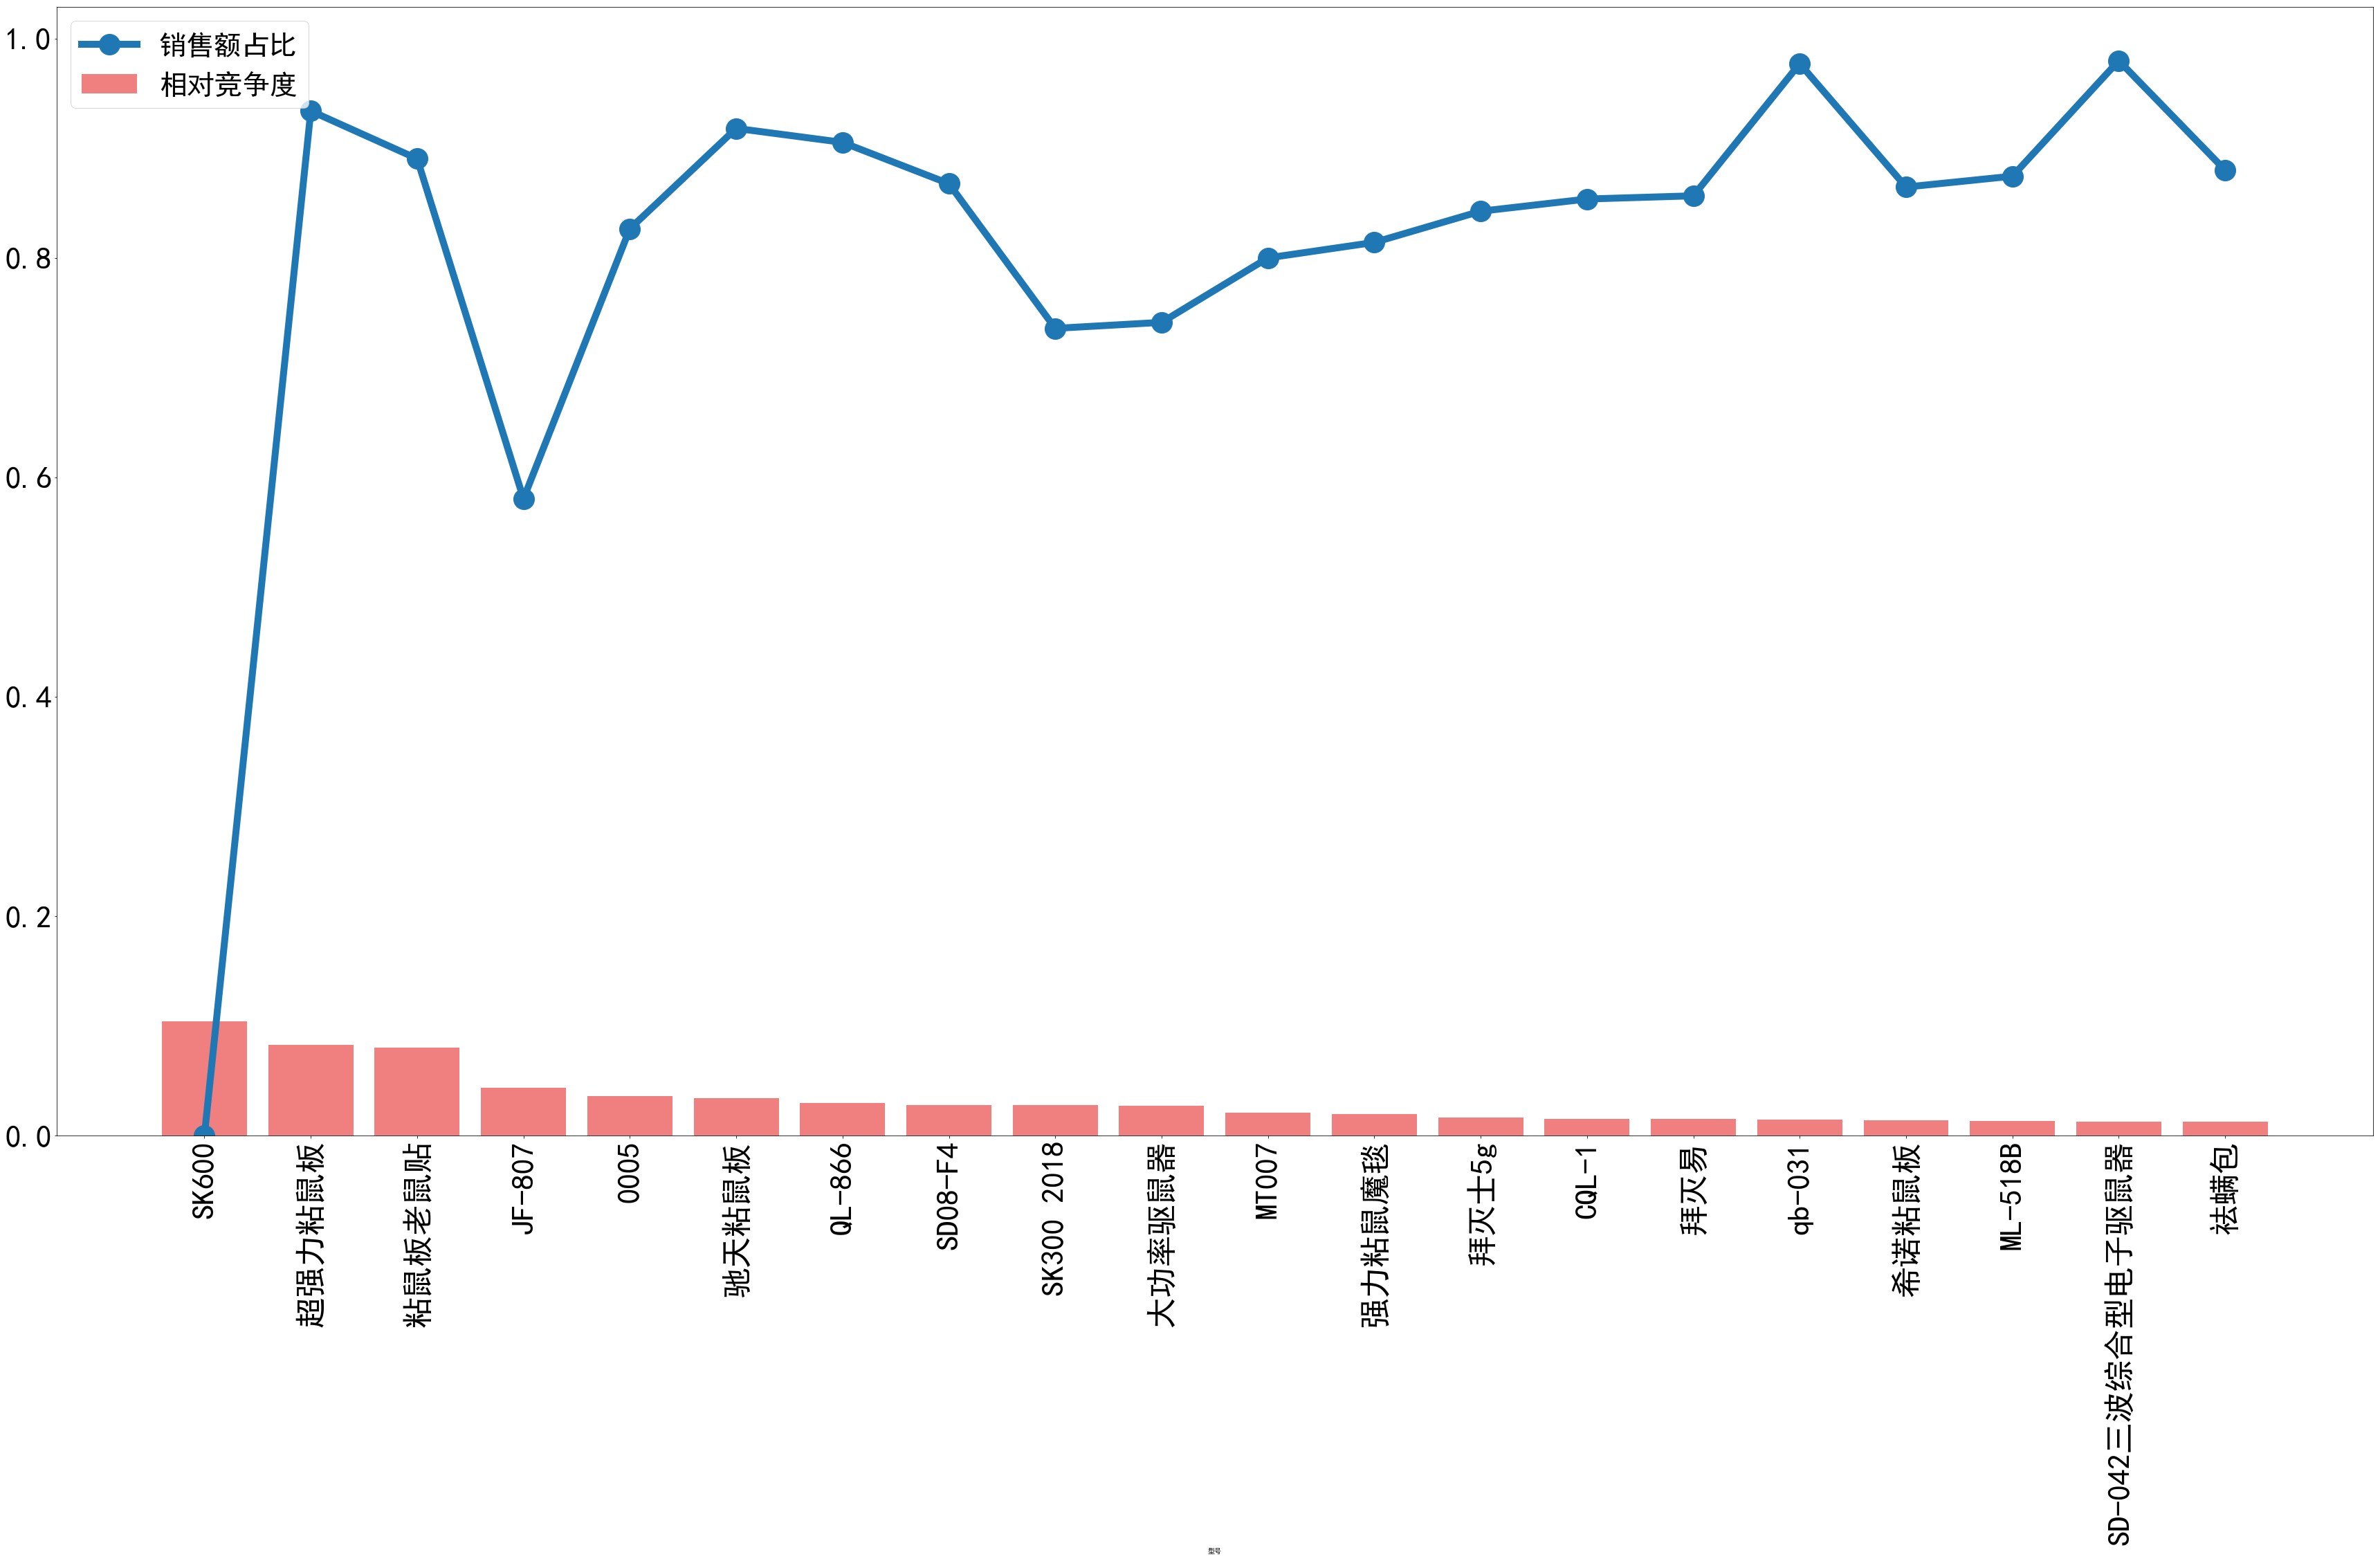

In [763]:
plt.figure(figsize=(60,30))
plt.bar(range(20),model_data['销售额占比'][:20],color='lightcoral')
plt.plot(range(20),model_data['相对竞争度'][:20],
         marker='o',linewidth=10,markersize=30)
plt.xlabel('型号')
plt.xticks(range(20),model_data.index[:20].tolist(),
           fontsize=45,rotation=90)
plt.yticks(fontsize=45)
#plt.xlim()
plt.legend(loc=2,fontsize=40,labels=['销售额占比','相对竞争度'])

- 可见虽然粘鼠板市场份额普遍较高,但是0005,MT007在竞争度上有明显的优势

### 物理形态分析

In [766]:
#按物理形态汇总数据
physical_data=rats_data[['物理形态','预估销售额','销售额占比']].groupby(by='物理形态').sum()
#计算不同宝贝数
physical_data=pd.concat((physical_data,
           rats_data[['物理形态','宝贝ID']].drop_duplicates().groupby(by='物理形态').count()),
          axis=1)
physical_data.rename(columns={'宝贝ID':'宝贝数'},inplace=True)
#计算宝贝数占比
physical_data['宝贝数占比']=physical_data['宝贝数']/physical_data['宝贝数'].sum()
# 计算相对竞争度
physical_data['单宝贝平均销售额']=physical_data['预估销售额']/physical_data['宝贝数']
physical_data['相对竞争度']=1-(physical_data['单宝贝平均销售额']-
 physical_data['单宝贝平均销售额'].min())/(physical_data['单宝贝平均销售额'].max()-
                                physical_data['单宝贝平均销售额'].min())
physical_data.sort_values(by='相对竞争度',inplace=True)
physical_data

,预估销售额,销售额占比,宝贝数,宝贝数占比,单宝贝平均销售额,相对竞争度
物理形态,,,,,,
胶水,534713.60,0.020817,1,0.001117,534713.600000,0.000000
8波段驱鼠器,108205.20,0.004213,1,0.001117,108205.200000,0.797844
服务,56160.00,0.002186,1,0.001117,56160.000000,0.895202
喷雾,275280.33,0.010717,6,0.006704,45880.055000,0.914433
固体,19664620.40,0.765577,789,0.881564,24923.473257,0.953635
粉状,329804.28,0.012840,14,0.015642,23557.448571,0.956190
啫喱,643694.50,0.025060,40,0.044693,16092.362500,0.970155
液体,445113.50,0.017329,28,0.031285,15896.910714,0.970520
5个1元硬币厚硬板,5226.00,0.000203,1,0.001117,5226.000000,0.990482


- 画图

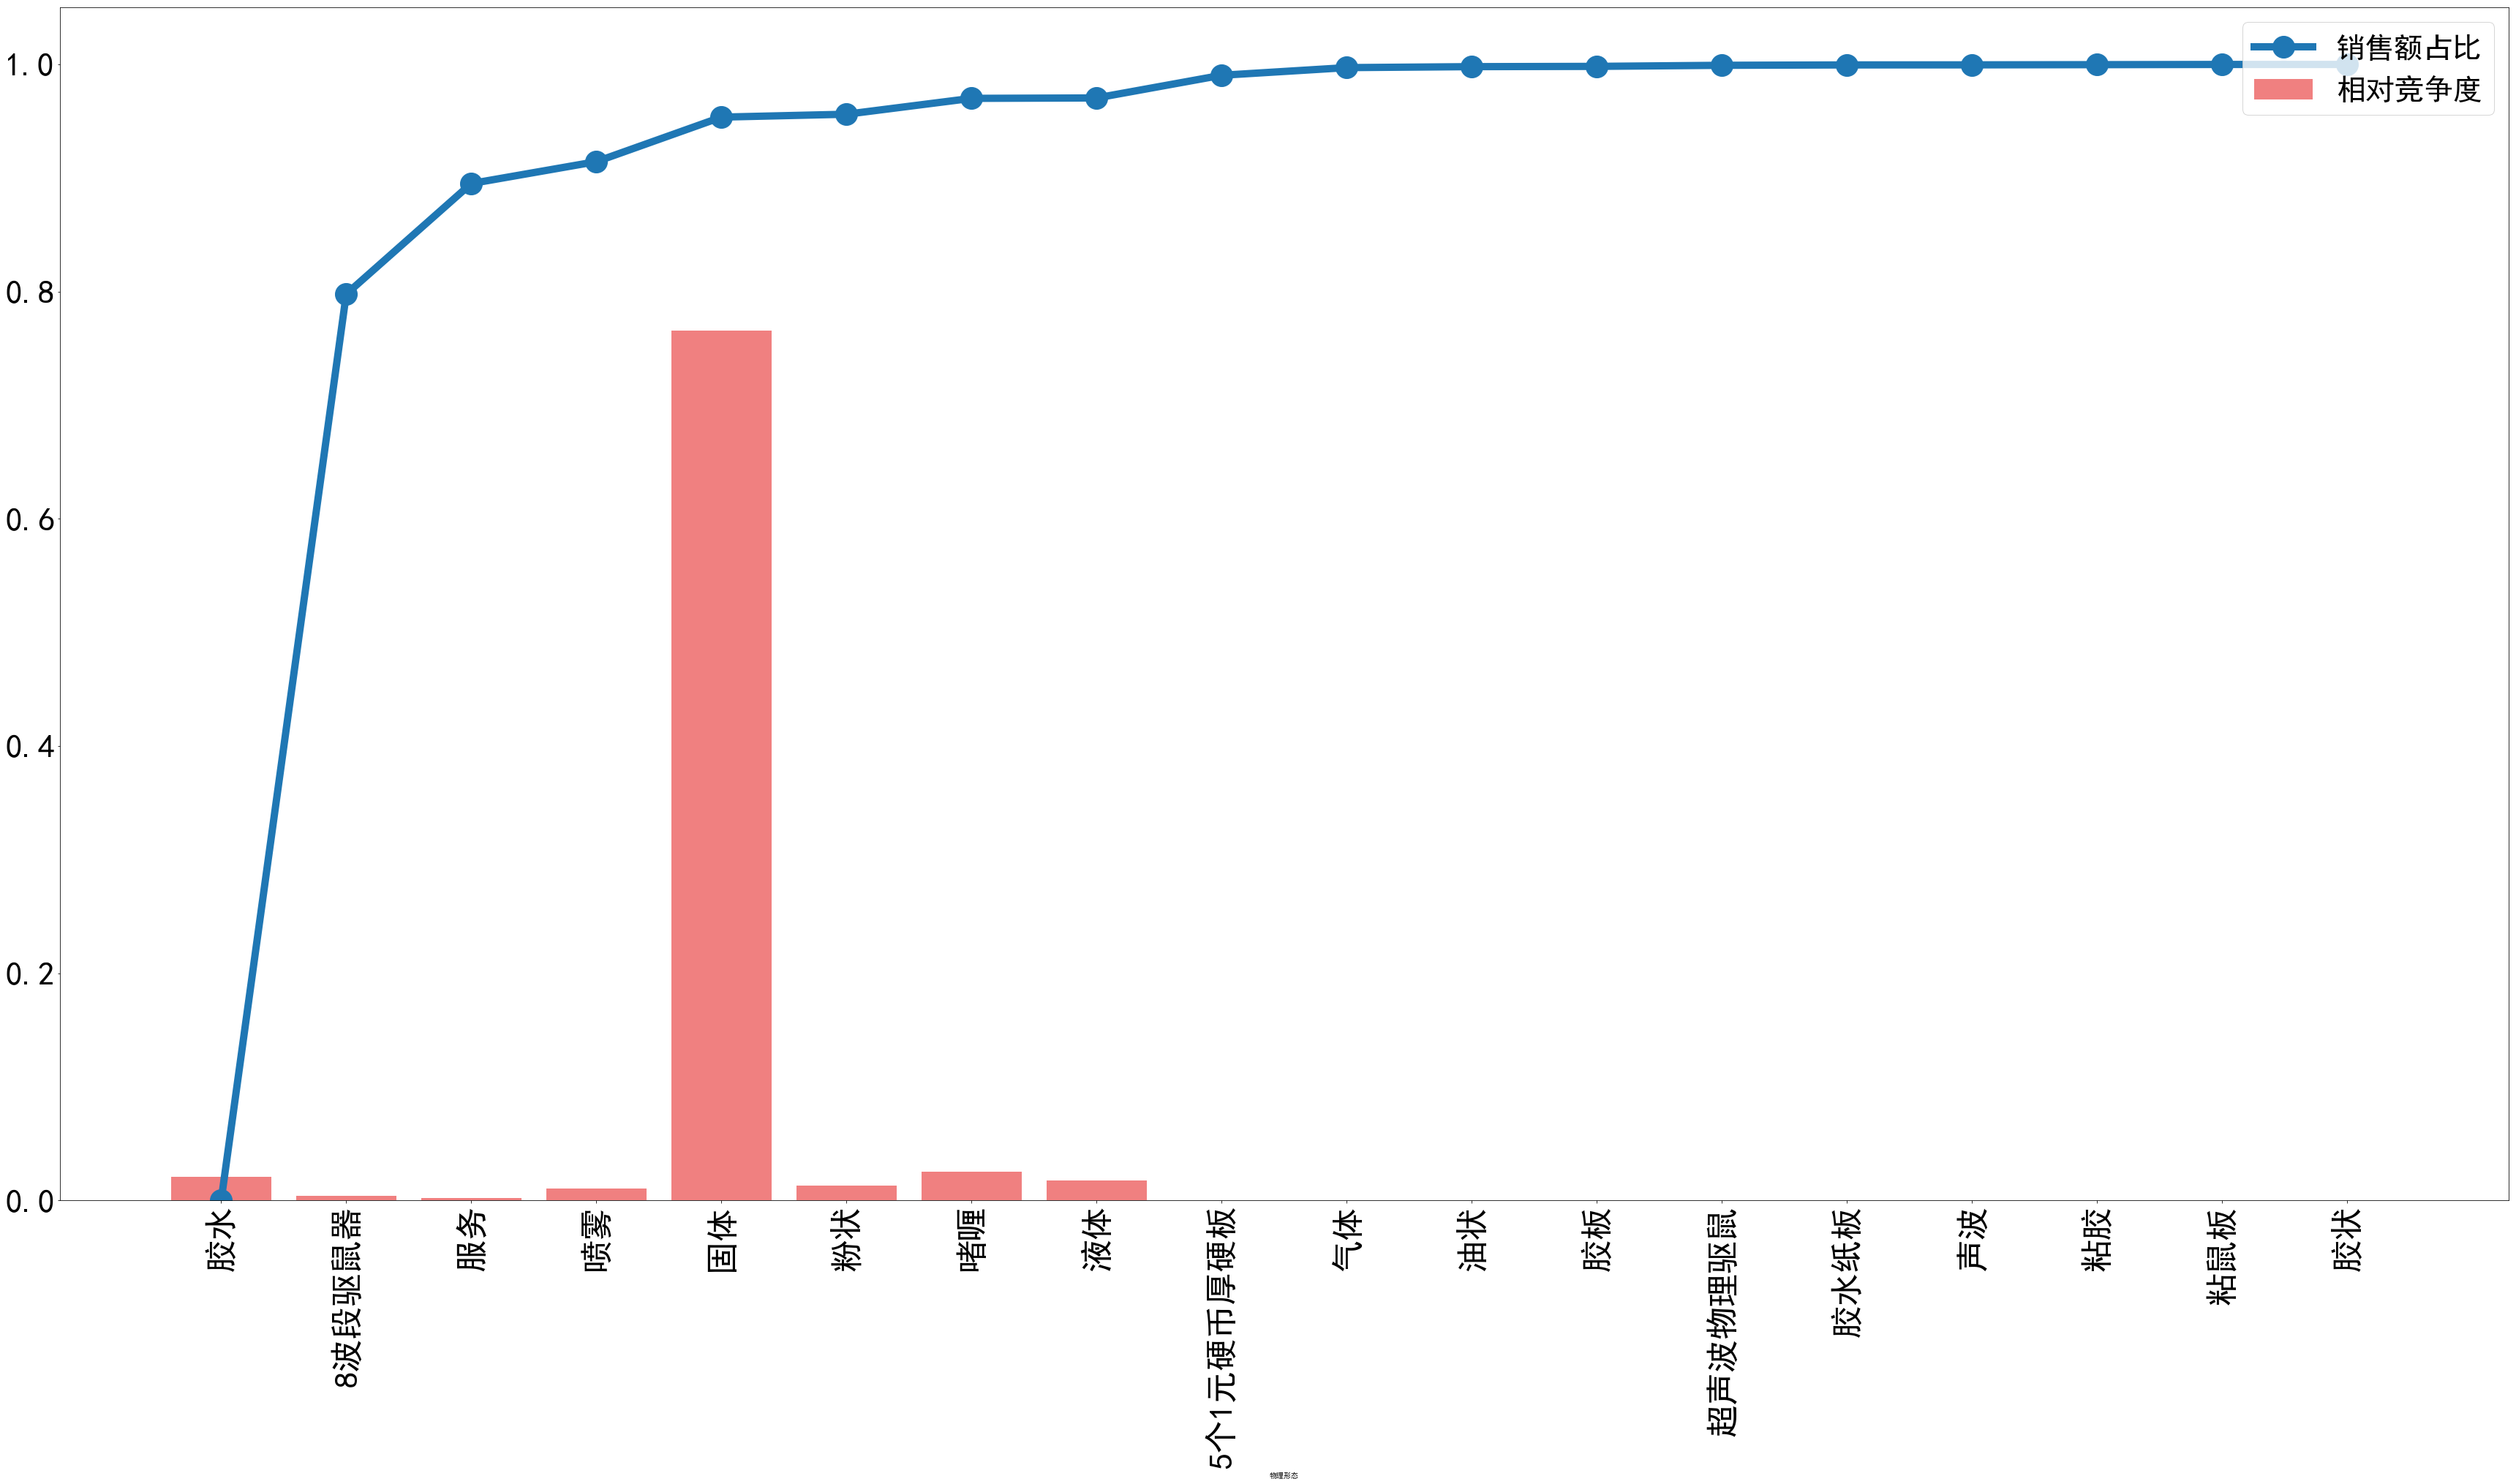

In [767]:
plt.figure(figsize=(60,30))
plt.bar(range(physical_data.shape[0]),physical_data['销售额占比'],color='lightcoral')
plt.plot(range(physical_data.shape[0]),physical_data['相对竞争度'],
         marker='o',linewidth=10,markersize=30)
plt.xlabel('物理形态')
plt.xticks(range(physical_data.shape[0]),physical_data.index.tolist(),
           fontsize=45,rotation=90)
plt.yticks(fontsize=45)
#plt.xlim()
plt.legend(loc=1,fontsize=40,labels=['销售额占比','相对竞争度'])

- 可见市场份额最高的是固体,竞争度也偏高,而胶水虽然竞争度低,但是市场份额较低
- 基本可以认为常见的物理形态就是固体

### 物理形态,净含量组合分析

In [45]:
#按物理形态,净含量组合汇总数据
phycon_data=rats_data[['物理形态','净含量','预估销售额','销售额占比']].groupby(by=['物理形态','净含量']).sum()
#计算不同宝贝数
phycon_data=pd.concat((phycon_data,
           rats_data[['物理形态','净含量','宝贝ID']].drop_duplicates().groupby(by=['物理形态','净含量']).count()),
          axis=1)
phycon_data.rename(columns={'宝贝ID':'宝贝数'},inplace=True)
#计算宝贝数占比
phycon_data['宝贝数占比']=phycon_data['宝贝数']/phycon_data['宝贝数'].sum()
# 计算相对竞争度
phycon_data['单宝贝平均销售额']=phycon_data['预估销售额']/phycon_data['宝贝数']
phycon_data['相对竞争度']=1-(phycon_data['单宝贝平均销售额']-
 phycon_data['单宝贝平均销售额'].min())/(phycon_data['单宝贝平均销售额'].max()-
                                phycon_data['单宝贝平均销售额'].min())
#phycon_data.sort_values(by='相对竞争度',inplace=True)
phycon_data

预估销售额         销售额占比  宝贝数     宝贝数占比       单宝贝平均销售额  \
物理形态   净含量                                                                 
8波段驱鼠器 台           108205.20  4.212612e-03    1  0.003077  108205.200000   
啫喱     0.18           105.00  4.087828e-06    1  0.003077     105.000000   
       10g           4452.80  1.733551e-04    2  0.006154    2226.400000   
       10克/支        40650.00  1.582573e-03    1  0.003077   40650.000000   
       12g         519383.40  2.022048e-02    2  0.006154  259691.700000   
       150            582.50  2.267771e-05    1  0.003077     582.500000   
       20g           2600.00  1.012224e-04    1  0.003077    2600.000000   
       240g            33.00  1.284746e-06    1  0.003077      33.000000   
       30g4            28.14  1.095538e-06    1  0.003077      28.140000   
       400g            29.90  1.164058e-06    1  0.003077      29.900000   
       40g             39.50  1.537802e-06    1  0.003077      39.500000   
       40克             19.50  7.591681e-07    1  0.003077      19.500000   
       45g            112.00  4.360350e-06    1  0.003077     112.000000   
       4g            2851.20  1.110021e-04    1  0.003077    2851.200000   
       50克            336.00  1.308105e-05    1  0.003077     336.000000   
       约50克             5.40  2.102312e-07    1  0.003077       5.400000   
喷雾     450ml          160.00  6.229071e-06    1  0.003077     160.000000   
       500ML          179.49  6.987850e-06    2  0.006154      89.745000   
       500ml          132.04  5.140541e-06    1  0.003077     132.040000   
       600ml       274808.80  1.069877e-02    2  0.006154  137404.400000   
固体     0             2352.00  9.156735e-05    1  0.003077    2352.000000   
       0.004立方米      1628.60  6.340416e-05    3  0.009231     542.866667   
       0.02             1.50  5.839754e-08    1  0.003077       1.500000   
       0.035          141.90  5.524408e-06    1  0.003077     141.900000   
       0.07            28.80  1.121233e-06    1  0.003077      28.800000   
       0.082           16.00  6.229071e-07    1  0.003077      16.000000   
       0.08kg           7.04  2.740791e-07    1  0.003077       7.040000   
       0.1             70.00  2.725219e-06    1  0.003077      70.000000   
       0.106kg        652.00  2.538347e-05    2  0.006154     326.000000   
       0.15           656.70  2.556644e-05    1  0.003077     656.700000   
...                      ...           ...  ...       ...            ...   
       6片             357.60  1.392197e-05    1  0.003077     357.600000   
       7-加大加粘款        660.00  2.569492e-05    1  0.003077     660.000000   
       720g          9412.20  3.664329e-04    1  0.003077    9412.200000   
       8              136.00  5.294711e-06    1  0.003077     136.000000   
       80G             59.40  2.312543e-06    1  0.003077      59.400000   
       831.5         1223.20  4.762125e-05    1  0.003077    1223.200000   
       g             3950.10  1.537841e-04    1  0.003077    3950.100000   
       一盒            4420.00  1.720781e-04    1  0.003077    4420.000000   
       个               10.00  3.893170e-07    1  0.003077      10.000000   
       约100克/个        103.48  4.028652e-06    1  0.003077     103.480000   
       胶水60克         1195.40  4.653895e-05    1  0.003077    1195.400000   
       胶水60克/张         34.00  1.323678e-06    1  0.003077      34.000000   
       陶土               8.80  3.425989e-07    1  0.003077       8.800000   
气体     30gm          1357.18  5.283732e-05    1  0.003077    1357.180000   
液体     0.3           9828.00  3.826207e-04    1  0.003077    9828.000000   
       100ml          111.86  4.354899e-06    1  0.003077     111.860000   
       2瓶喷剂+2罐驱鼠灵    7188.00  2.798410e-04    1  0.003077    7188.000000   
       450            180.00  7.007705e-06    1  0.003077     180.000000   
       450ML        51494.78  2.004779e-03    2  0.006154   25747.390000   
       450ml        37570.20  1.462672e-03    4  0.012308    9392.55000

- 画图

In [46]:
plt.figure(figsize=(200,100))
plt.bar(range(phycon_data.shape[0]),phycon_data['销售额占比'],color='lightcoral')
plt.plot(range(phycon_data.shape[0]),phycon_data['相对竞争度'],
         marker='o',linewidth=10,markersize=30)
plt.xlabel('物理形态-净含量')
plt.xticks(range(phycon_data.shape[0]),phycon_data.index.tolist(),
           fontsize=45,rotation=90)
plt.yticks(fontsize=45)
#plt.xlim()
plt.legend(loc=1,fontsize=40,labels=['销售额占比','相对竞争度'])

- 可见当物理形态为固体,净含量为1时,潜力较大

## 结论

- 灭鼠杀虫剂市场中,需要重点关注的产品类别是:灭鼠和蟑螂
- 灭鼠中：
  - 最大的市场集中在0-50的价格段,这个价格段竞争也很激烈
  - 200-250这个价格段市场份额占10%左右,竞争度很低,是值得挖掘的高价市场
- 灭鼠0-50价格段的产品市场中: 
  - 10-20价格段市场容量大,竞争度低,值得进一步开发,20-30也不错
  - 店铺类型方面天猫明显优于淘宝
  - 市场份额高的型号是粘鼠板,然而型号0005市场份额还行,竞争度较低,值得开发
  - 产品的物理形态基本都是固体,也是被大众认可的形态
  - 当物理形态为固体,净含量为1时,市场份额高竞争度低,值得开发

# 竞争分析

- 依据之前的top100品牌数据,分析市场份额前三的商家:拜耳,科凌虫控,安速

## 分析思路

- 人群画像分析:三个品牌的人群特征基本一致
- 品类分布:依据各个商家产品类别和适用对象的分布,理解每个品牌的产品分布情况(横向发展还是纵向发展)
- 产品结构:依据波士顿矩阵,分析各品牌不同产品的结构特征,为产品发展策略提供依据
- 流量结构:通过流量结构和流量效果的对比,制定推广策略
- 产品舆情:优质产品维稳

In [47]:
os.chdir('..')#返回上一级目录，若需要返回前两级目录，此命令执行两次
os.getcwd()

'E:\\Data analysis\\CDA\\learning\\0、python自己练习\\7、项目实战\\data\\电商文本'

In [48]:
os.chdir(r'.\竞争数据\商品销售数据')

In [52]:
sale_data=pd.DataFrame()
for fname in os.listdir():   
    if re.search(r'\.xlsx$',fname):
        # 读取数据
        df=pd.read_excel(fname) 
        sale_data=pd.concat((sale_data,df),ignore_index=True)

D:\tool\anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [55]:
sale_data.head(1)

,30天销售量,30天销售额,主图链接,使用对象,净含量,商品ID,商品原价,商品名称,商品售价,商品链接,型号,序号,店铺名称,总销量,物理形态,类目,适用对象,销售额
0,2540,138176.0,http://img.alicdn.com/bao/uploaded/i3/27967673...,NaN,NaN,527032566392,60.0,日本进口安速小强恢恢灭蟑螂屋药无毒捕捉器克星家用强力清全窝端,54.4,https://detail.m.tmall.com/item.htm?id=5270325...,NaN,1,安速家居旗舰店,236321,NaN,灭鼠/杀虫剂,蟑螂,NaN


- 处理缺失值：
  - 缺失值的产生是因为读取数据时列名不一致导致的

In [62]:
sale_data['30天销售额'].fillna(sale_data['销售额'],inplace=True)
sale_data['适用对象'].fillna(sale_data['使用对象'],inplace=True)

In [125]:
sale_data['店铺名称']=sale_data.店铺名称.str.replace('旗舰店','')
sale_data['店铺名称']=sale_data.店铺名称.str.replace('家居','')
sale_data['店铺名称']=sale_data.店铺名称.str.replace('官方','')

## 品类分布分析

In [88]:
type_sale=sale_data[['30天销售额','店铺名称','类目']].groupby(by=['店铺名称','类目']).sum()
type_sale.reset_index(inplace=True)

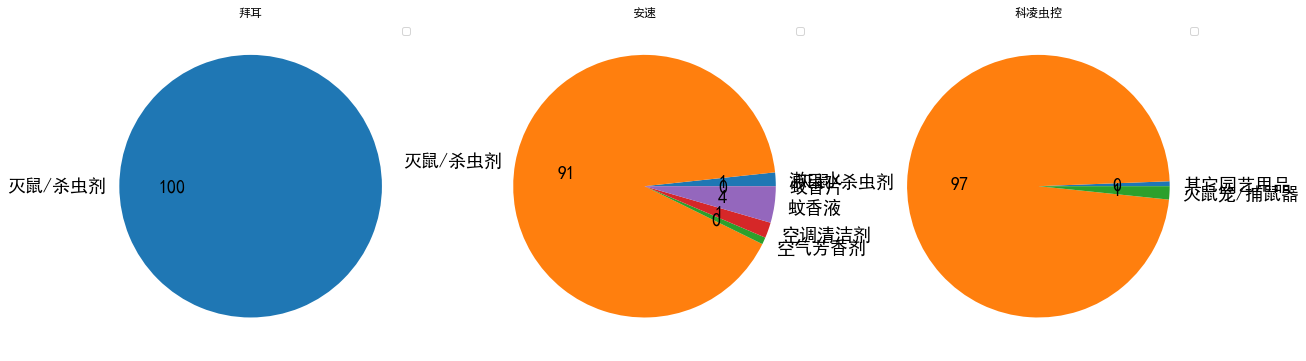

In [133]:
fig,ax=plt.subplots(1,3,figsize=(20,8))
cols=['拜耳','安速','科凌虫控']
for i in range(len(cols)):
    df=type_sale[type_sale['店铺名称']==str(cols[i])].iloc[:,1:].copy()
    df.set_index(df['类目'],inplace=True)
    df.drop(columns='类目',inplace=True)
    df.plot.pie(y='30天销售额',ax=ax[i],autopct='%0d',fontsize=18)
    ax[i].set_title(str(cols[i]))
    ax[i].set_ylabel('')
    ax[i].legend('')
   

- 可见拜耳只有一个市场，其他的有不同市场，但主要市场都是灭鼠杀虫剂

## 适用对象分析

In [126]:
obj_sale=sale_data[['30天销售额','店铺名称','适用对象']].groupby(by=['店铺名称','适用对象']).sum()
obj_sale.reset_index(inplace=True)

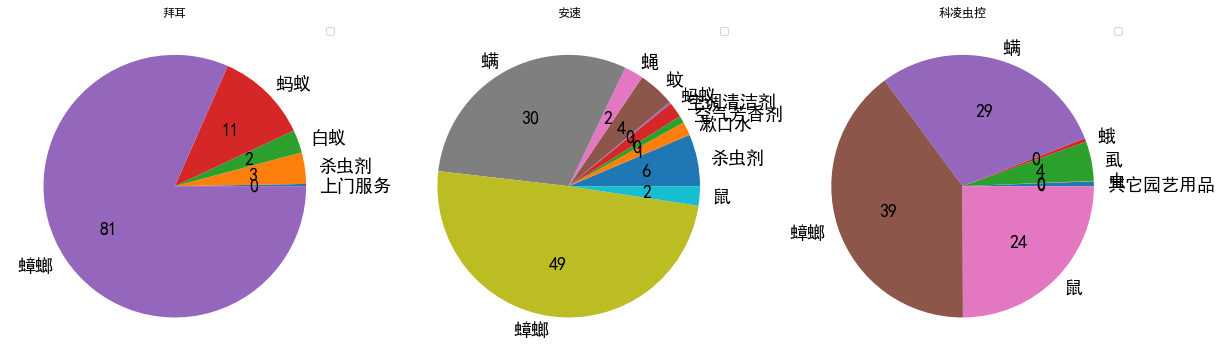

In [132]:
fig,ax=plt.subplots(1,3,figsize=(20,8))
cols=['拜耳','安速','科凌虫控']
for i in range(len(cols)):
    df=obj_sale[obj_sale['店铺名称']==str(cols[i])].iloc[:,1:].copy()
    df.set_index(df['适用对象'],inplace=True)
    df.drop(columns='适用对象',inplace=True)
    df.plot.pie(y='30天销售额',ax=ax[i],autopct='%0d',fontsize=18)
    ax[i].set_title(str(cols[i]))
    ax[i].set_ylabel('')
    ax[i].legend('')

- 拜耳的主要对象是蟑螂,而另外两家除此之外还有螨，鼠
- 而从之前的分析看灭鼠和蟑螂的整体市场份额都大
- 应该开拓新市场,尤其是灭鼠,也考察其他两家都开拓的螨市场

## 产品结构分析

- 使用商品交易数据,每个竞争者分开分析,先分析拜耳的数据

- 读取数据

In [135]:
os.chdir('..')  #返回上一级目录，若需要返回前两级目录，此命令执行两次
pwd()

In [138]:
os.chdir(r'.\商品交易数据')  #定位到文件所处位置

In [154]:
brand_data=pd.DataFrame()
for fnames in os.listdir():
    fname=re.match('(.*?)全店',fnames).groups()[0]
    df=pd.read_excel(fnames,date_parser=['时间','日期'])
    df['品牌']=fname
    brand_data=pd.concat((brand_data,df),ignore_index=True) 
brand_data['日期'].fillna(brand_data['时间'],inplace=True)

D:\tool\anaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


### 拜耳

In [164]:
baier_data=brand_data[brand_data['品牌']=='拜耳']

In [179]:
baier_goods_data=baier_data[['商品','交易增长幅度','交易金额']].groupby(by='商品').sum()
baier_goods_data['交易额占比']=baier_goods_data['交易金额']/baier_goods_data['交易金额'].sum()
baier_goods_data['商品个数']=baier_data[['商品','日期']].groupby(by='商品').count()
baier_goods_data.head()

,交易增长幅度,交易金额,交易额占比,商品个数
商品,,,,
17年德国拜耳进口蚂蚁药拜灭易灭蚁饵剂粉除杀蚂蚁杀虫剂全窝端,-0.2476,42340.55,0.000523,1
德国原装进口拜耳蟑螂药全窝端拜灭士5g+12g杀蟑胶饵剂粉屋捕捉器,-0.3610,197377.17,0.002439,3
德国拜耳 除敌跳蚤杀虫剂家用灭蟑螂药虱子杀潮虫臭虫除虫剂喷雾,-1.1054,1394780.59,0.017232,5
德国拜耳丁香医生限量款拜灭士加量家用蟑螂全窝端蟑螂药3支装,1.2793,26742.75,0.000330,1
德国拜耳上门除灭鼠灭白蚁蟑螂蚊子跳蚤苍蝇上海地区灭虫按件拍下,2.4393,28969.28,0.000358,1


In [180]:
baier_goods_data.describe()

,交易增长幅度,交易金额,交易额占比,商品个数
count,44.000000,4.400000e+01,44.000000,44.000000
mean,25.855968,1.839560e+06,0.022727,3.227273
std,155.038089,6.321050e+06,0.078095,1.668639
min,-1.168400,2.255362e+04,0.000279,1.000000
25%,-0.238675,6.828508e+04,0.000844,1.750000
50%,0.395550,2.061879e+05,0.002547,3.000000
75%,2.213400,7.673291e+05,0.009480,5.000000
max,1030.000000,4.010385e+07,0.495473,5.000000


- 其中交易增长幅度可表示市场发展率,交易金额占比可表示市场份额
- 这两个指标的最大值都远大于3/4分位数,认为是异常值,考虑引入盖帽法,方便作图

- 盖帽法填充数据函数

In [185]:
def get_block(df):
    ql=df.quantile(0.9)
    df=df.mask(df>ql,ql)
    out=df.copy()
    return out

- 定义画波士顿矩阵图

In [205]:
def plot_BCG(df,plot_m=False,q_h=0.5,q_v=0.5):
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.rcParams['font.sans-serif']='SimHei'
    plt.rcParams['axes.unicode_minus']=False
    
    f,ax=plt.subplots(figsize=(10,8))
    
    ax=sns.scatterplot(x='交易额占比',y='交易增长幅度',
                       hue='商品个数',size='商品个数',
                       sizes=(20,200),palette='cool',legend='full',data=df)
    #若plot_m为True,用两个指标的平均值做标线
    #若plot_m为False,用两个指标的中位数做标线
    if plot_m:
        plt.axhline(df['交易增长幅度'].mean())
        plt.axvline(df['交易额占比'].mean())
    else:
        plt.axhline(df['交易增长幅度'].quantile(q_h))
        plt.axvline(df['交易额占比'].quantile(q_v))
    plt.show()


- 清洗数据

In [182]:
baier_plot=baier_goods_data.copy()
baier_plot['交易增长幅度']=get_block(baier_plot['交易增长幅度'])
baier_plot['交易额占比']=get_block(baier_plot['交易额占比'])

- 画BCG图

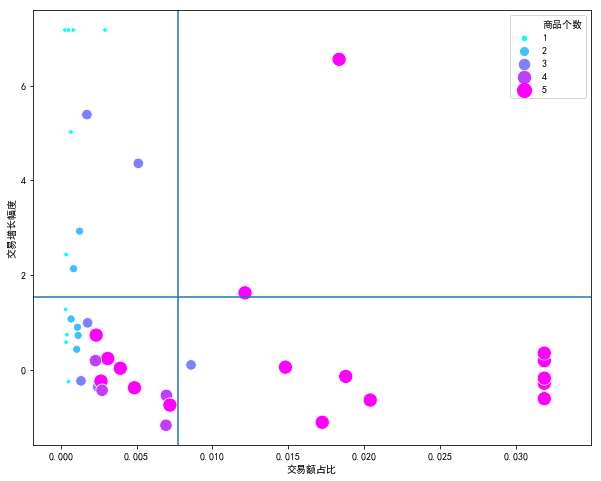

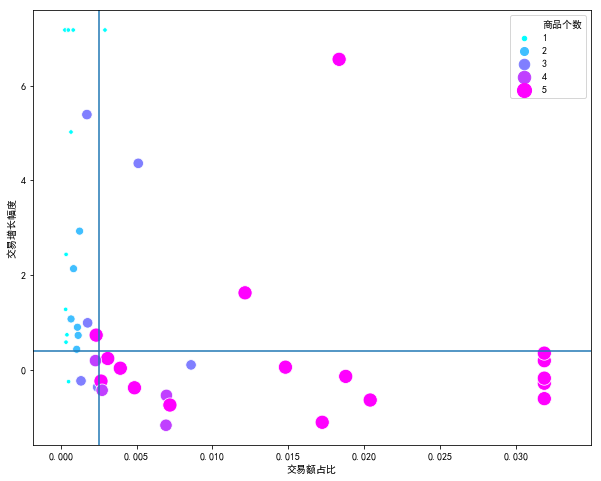

In [207]:
plot_BCG(baier_plot,plot_m=True)  #按平均值画图
plot_BCG(baier_plot)              #按中位数画图

- 可以根据实际的业务选择区间的分隔线,由行业经验确定(如果认为增幅0.1在行业里算高,就可以作为分隔线)
- 明星产品和奶牛产品的商品个数普遍比较多
- 没有突出的明星产品,但是有快进入明星产品的问题产品

- 查看各个产品结构的产品(除了瘦狗)
- 各种产品排序,关心点不同,排序依据不同
    - 明星产品:都关心,依什么排序都可以,产品一般不多
    - 奶牛产品:老爆款,关心市场份额,依交易金额占比排序
    - 问题产品,潜力款,关心市场增长率,依交易增长幅度排序
- 这里要查看实际数据,故使用盖帽前数据

In [208]:
baier_goods_data.head()

,交易增长幅度,交易金额,交易额占比,商品个数
商品,,,,
17年德国拜耳进口蚂蚁药拜灭易灭蚁饵剂粉除杀蚂蚁杀虫剂全窝端,-0.2476,42340.55,0.000523,1
德国原装进口拜耳蟑螂药全窝端拜灭士5g+12g杀蟑胶饵剂粉屋捕捉器,-0.3610,197377.17,0.002439,3
德国拜耳 除敌跳蚤杀虫剂家用灭蟑螂药虱子杀潮虫臭虫除虫剂喷雾,-1.1054,1394780.59,0.017232,5
德国拜耳丁香医生限量款拜灭士加量家用蟑螂全窝端蟑螂药3支装,1.2793,26742.75,0.000330,1
德国拜耳上门除灭鼠灭白蚁蟑螂蚊子跳蚤苍蝇上海地区灭虫按件拍下,2.4393,28969.28,0.000358,1


In [218]:
def get_BCG_data(df,q1=0.5,q2=0.5,by='交易额占比'):
    q_1=df['交易增长幅度'].quantile(q1)
    q_2=df['交易额占比'].quantile(q2)
    
    #计算明星产品
    star=df[((df['交易增长幅度']>=q_1) & (df['交易额占比']>=q_2))].copy().sort_values(by=by,ascending=False)
    
    #计算奶牛产品
    cow=df[((df['交易增长幅度']<q_1) & (df['交易额占比']>=q_2))].copy().sort_values(by=by,ascending=False)
    
    #计算问题产品
    problem=df[((df['交易增长幅度']>=q_1) & (df['交易额占比']<q_2))].copy().sort_values(by=by,ascending=False)
    
    #计算瘦狗产品
    thin_dog=df[((df['交易增长幅度']<q_1) & (df['交易额占比']<q_2))].copy().sort_values(by=by,ascending=False)
    
    return (star,cow,problem,thin_dog)

In [219]:
baistar,baicow,baique,baidog = get_BCG_data(baier_goods_data)
baistar1,baicow1,baique1,baidog1 = get_BCG_data(baier_goods_data,by='交易增长幅度')

- 拜耳明星产品

In [220]:
baistar

,交易增长幅度,交易金额,交易额占比,商品个数
商品,,,,
德国拜耳拜灭士5g+除敌5ml*4支进口蟑螂药家用全窝端杀蟑螂套装,6.5587,1484952.41,0.018346,5
德国拜耳除敌杀虫剂灭蟑螂药跳蚤苍蝇臭虫除螨虱子喷雾5ml*8,1.6279,983199.69,0.012147,5
拜耳拜灭士 蟑螂药家用全窝端 强力灭除厨房蟑螂屋克星杀德国进口,4.3622,413902.42,0.005114,3
德国拜耳拜灭士蟑螂药一窝端进口全窝端家用灭除杀蟑胶饵5g包邮,29.2606,236386.32,0.002920,1


- 主要是除蟑和杀虫,但是占比不大,增幅一般

- 拜耳奶牛产品/老爆款

In [221]:
baicow

,交易增长幅度,交易金额,交易额占比,商品个数
商品,,,,
德国拜耳拜灭士蟑螂药一窝端杀蟑胶饵灭蟑螂屋无毒克星家用全窝端,-0.6068,40103850.97,0.495473,5
进口蟑螂药一窝端德国拜耳拜灭士强力杀蟑胶饵蟑螂屋克星家用全窝,-0.1734,13617307.87,0.168238,5
德国拜耳进口蚂蚁药拜灭易灭蚁饵剂除杀蚂蚁杀虫剂家用室内全窝端,-0.2812,6130488.42,0.075741,5
进口蟑螂药德国拜耳拜灭士灭杀蟑胶饵剂粉屋克星全窝端12g家用,0.3548,3589799.54,0.044351,5
蟑螂药一窝端德国拜耳拜灭士除蟑灭杀蟑螂克星全窝端家用杀蟑胶,0.1945,2976922.63,0.036779,5
进口蟑螂药德国拜耳拜灭士杀蟑胶饵蟑螂克星全窝端家用灭蟑屋12g,-0.6357,1650681.34,0.020394,5
德国拜耳拜灭易灭蚁饵剂粉除杀防蚂蚁药杀虫剂全窝端家用室内花园,-0.1365,1520126.15,0.018781,5
德国拜耳 除敌跳蚤杀虫剂家用灭蟑螂药虱子杀潮虫臭虫除虫剂喷雾,-1.1054,1394780.59,0.017232,5
蟑螂药德国拜耳拜灭士强力除杀蟑螂克星胶饵屋家用捕捉器贴全窝端,0.0584,1198694.67,0.014810,5


- 可见占比最高的是除蟑,灭虫也占一部分,占比一般

- 拜耳问题产品/潜力款

In [222]:
baique1

,交易增长幅度,交易金额,交易额占比,商品个数
商品,,,,
电子猫超声波驱鼠器家用大功率灭鼠防鼠赶老鼠夹药捕鼠干扰粘鼠板,1030.0000,41046.03,0.000507,1
进口蟑螂药一窝端德国拜耳拜灭士杀蟑胶饵诱防蟑螂屋全窝端5+12g,31.2185,67043.14,0.000828,1
德国拜耳拜灭易进口蚂蚁药一窝端灭蚁饵剂清除蚂蚁粉家用全窝端,7.8670,32246.39,0.000398,1
拜耳灭蚂蚁药家用一窝端室内室外用杀小黄红蚂蚁药神器胶饵拜灭易,7.4427,22553.62,0.000279,1
拜灭士蟑螂药蟑螂克星家用无毒强力灭蟑清德国拜耳杀蟑饵剂全窝端,5.3918,140032.47,0.001730,3
德国拜耳白蚁药杀虫剂全窝端家用除杀防治灭飞蚂蚁特密得预防装修,5.0238,55113.41,0.000681,1
蟑螂药进口德国拜耳拜灭士家用除杀蟑螂屋胶饵捕捉器强力清全窝端,2.9307,101079.33,0.001249,2
德国拜耳上门除灭鼠灭白蚁蟑螂蚊子跳蚤苍蝇上海地区灭虫按件拍下,2.4393,28969.28,0.000358,1
德国拜耳蟑螂药拜灭士杀蟑胶饵蟑螂克星全窝端家用灭蟑加量装12g,2.1381,68699.06,0.000849,2


- 可见大部分仍然是灭蟑和杀虫
- 交易增长幅度最大的是灭鼠,而之前描述过灭鼠有最高的市场份额,可以作为下一步着力点

- 总结:拜耳大部分产品集中在除蟑上,杀虫也有一定的规模,但是明星产品略乏力,可以进一步发展问题产品灭鼠为明星产品

### 安速

- 获取数据

In [223]:
ansu_data=brand_data[brand_data['品牌']=='安速']

In [227]:
ansu_goods_data=ansu_data[['商品','交易增长幅度','交易金额']].groupby(by='商品').sum()
ansu_goods_data['交易额占比']=ansu_goods_data['交易金额']/ansu_goods_data['交易金额'].sum()
ansu_goods_data['商品个数']=ansu_data[['商品','日期']].groupby(by='商品').count()
ansu_goods_data.head()

,交易增长幅度,交易金额,交易额占比,商品个数
商品,,,,
10枚装日本进口安速小强恢恢蟑螂屋诱捕捉器杀药贴环保无毒包邮,0.7070,217061.51,0.007203,4
✅【10枚装】日本进口安速小强恢恢蟑螂屋捕捉器杀药贴家用全窝端,-0.7989,812113.82,0.026948,5
【20枚装】日本进口安速小强恢恢蟑螂屋蟑螂捕捉器诱捕器灭蟑小屋,1.8643,58785.41,0.001951,2
【6枚装】日本安速小强恢恢蟑螂屋捕捉器药厨房灭杀强力家用贴清,0.0473,33178.59,0.001101,1
冲销量日本安速小黑帽蟑螂屋蟑螂药家用强力灭蟑清安全无毒小强,42.0143,32034.34,0.001063,1


In [228]:
ansu_goods_data.describe()

,交易增长幅度,交易金额,交易额占比,商品个数
count,49.000000,4.900000e+01,49.000000,49.000000
mean,3.881865,6.150227e+05,0.020408,2.877551
std,16.343690,1.954368e+06,0.064851,1.666241
min,-1.274200,1.916612e+04,0.000636,1.000000
25%,-0.059700,4.044140e+04,0.001342,1.000000
50%,0.362000,1.162554e+05,0.003858,3.000000
75%,1.024700,4.153983e+05,0.013784,5.000000
max,107.320700,1.329498e+07,0.441164,5.000000


- 清洗数据

In [229]:
ansu_plot=ansu_goods_data.copy()
ansu_plot['交易增长幅度']=get_block(ansu_plot['交易增长幅度'])
ansu_plot['交易额占比']=get_block(ansu_plot['交易额占比'])

- 画图

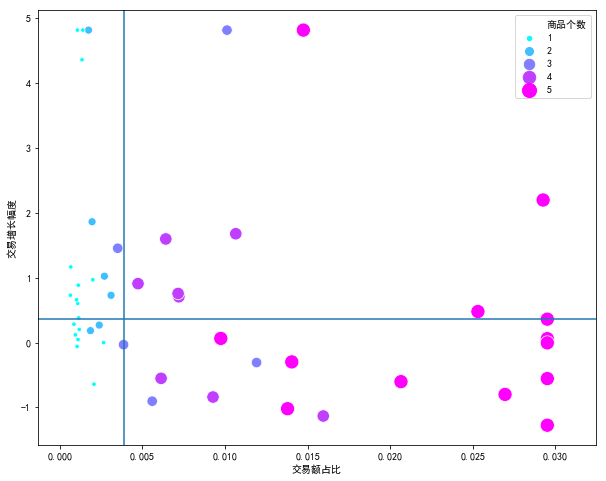

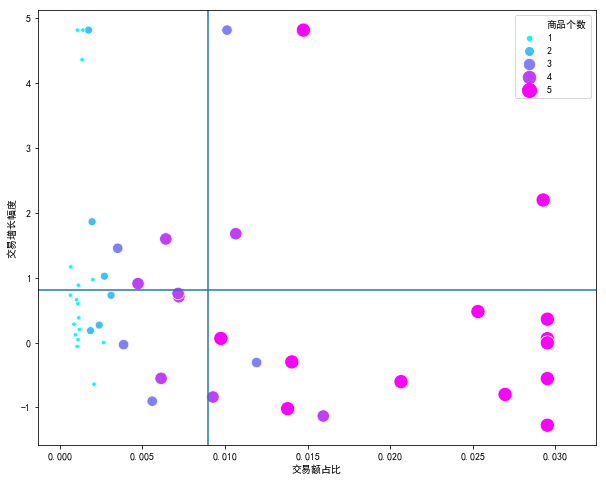

In [230]:
plot_BCG(ansu_plot)
plot_BCG(ansu_plot,plot_m=True)

In [231]:
ansustar,ansucow,ansuque,ansudog = get_BCG_data(ansu_goods_data)
ansustar1,ansucow1,ansuque1,ansudog1 = get_BCG_data(ansu_goods_data,by='交易增长幅度')

- 安速明星产品

In [232]:
ansustar

,交易增长幅度,交易金额,交易额占比,商品个数
商品,,,,
日本安速小黑帽蟑螂屋家用强力灭蟑螂药环保无毒无味除小强包邮,0.3620,1083611.82,0.035957,5
日本安速蟑螂小屋灭除杀蟑螂药一窝端神器捕捉器家用克星小强恢恢,2.2000,881587.79,0.029254,5
日本安速红阿斯烟雾杀虫剂灭跳蚤药烟弹家用神器螨虫克星送蟑螂屋,0.4796,762628.32,0.025306,5
日本安速蚂蚁药灭蚂蚁清驱除杀红蚂蚁小黄蚂蚁全窝端家用室内花园,107.3207,444230.43,0.014741,5
日本安速小黑帽小强黑克杀蟑饵剂9枚 蟑螂药屋蟑螂克星家用全窝端,1.6796,320927.90,0.010649,4
日本进口安速天然除螨喷雾剂350ml床上免洗家用正品螨虫非除杀菌,11.5780,304915.11,0.010118,3
10枚装日本进口安速小强恢恢蟑螂屋诱捕捉器杀药贴环保无毒包邮,0.7070,217061.51,0.007203,4
日本进口安速小强恢恢蟑螂屋5片药捕捉器灭杀蟑螂克星家用全窝端,0.7584,215689.30,0.007157,4
日本安速红阿斯杀虫烟雾剂20g弹烟熏灭跳蚤蟑螂药克星家用全窝端,1.5992,193282.28,0.006414,4


- 杀虫和除蟑表现都不错

- 安速奶牛产品

In [233]:
ansucow

,交易增长幅度,交易金额,交易额占比,商品个数
商品,,,,
日本安速小强恢恢蟑螂屋纸盒子捕捉器药灭杀强力家用贴克星全窝端,0.0609,13294975.97,0.441164,5
日本进口安速小强恢恢灭蟑螂屋药无毒捕捉器克星家用强力清全窝端,-0.5550,3685204.19,0.122285,5
日本进口安速小强恢恢杀蟑灭蟑螂屋10枚捕捉器不含蟑螂药,-0.0037,2354769.41,0.078138,5
日本安速小强恢恢蟑螂屋家用杀蟑胶饵小蟑螂药无毒蟑螂克星全窝端,-1.2742,919683.22,0.030518,5
✅【10枚装】日本进口安速小强恢恢蟑螂屋捕捉器杀药贴家用全窝端,-0.7989,812113.82,0.026948,5
日本进口安速红阿斯杀虫烟雾剂弹烟熏灭跳蚤蟑螂克星家用全窝端,-0.6023,622279.57,0.020649,5
原装进口日本安速红阿斯杀虫烟雾剂熏杀灭跳蚤臭虫螨虫蟑螂20克,-1.1320,480525.86,0.015945,4
日本安速小强恢恢蟑螂屋捕捉器神器厨房清灭强力贴克星家用全窝端,-0.2975,423102.79,0.014040,5
日本安速小强恢恢蟑螂屋药6片 无毒捕捉器强力灭清克星家用全窝端,-1.0199,415398.34,0.013784,5


- 主要是除蟑,和拜耳产生竞争

- 安速问题产品

In [234]:
ansuque1

,交易增长幅度,交易金额,交易额占比,商品个数
商品,,,,
冲销量日本安速小黑帽蟑螂屋蟑螂药家用强力灭蟑清安全无毒小强,42.0143,32034.34,0.001063,1
日本安速杀蟑气雾剂精纯无味型2瓶 灭蟑螂药杀虫剂家用潮虫百虫灵,6.8966,52292.37,0.001735,2
日本安速除螨虫喷雾剂床上免洗去螨虫神器喷剂家用非杀菌送除螨包,6.6480,41991.71,0.001393,1
日本安速ARS地球制药earth小飞虫恢恢果蝇诱捕器单只装 0315,4.3643,40441.40,0.001342,1
【20枚装】日本进口安速小强恢恢蟑螂屋蟑螂捕捉器诱捕器灭蟑小屋,1.8643,58785.41,0.001951,2
现货 日本正品安速小黑帽蟑螂屋杀小强灭蟑螂药环保无毒无刺激,1.4556,105556.48,0.003503,3
日本进口安速小强恢恢蟑螂屋5片家用无毒贴捕捉器克星家用全窝端,1.1675,19943.68,0.000662,1
日本ARS安速小黑帽蟑螂屋盒子无毒无味灭小强安全室内12枚蟑螂药,1.0247,81303.15,0.002698,2
日本安速红阿斯杀虫烟雾剂弹10g烟熏灭跳蚤蟑螂克星家用全窝端,0.9705,60200.62,0.001998,1


- 前几款是灭蟑,除螨,杀虫,都有发展空间

- 总结:安速没有明显的灭鼠市场
- 拜耳和安速比较:拜耳杀虫是老爆款,灭蟑存在一定竞争

### 科凌虫控

- 获取数据

In [235]:
klck_data=brand_data[brand_data['品牌']=='科凌虫控']

In [236]:
klck_goods_data=klck_data[['商品','交易增长幅度','交易金额']].groupby(by='商品').sum()
klck_goods_data['交易额占比']=klck_goods_data['交易金额']/klck_goods_data['交易金额'].sum()
klck_goods_data['商品个数']=klck_data[['商品','日期']].groupby(by='商品').count()
klck_goods_data.head()

,交易增长幅度,交易金额,交易额占比,商品个数
商品,,,,
4 只装驱老鼠夹捕鼠器家用灭鼠神器抓杀扑老鼠夹子捉老鼠笼全自动,0.2740,289907.35,0.006233,5
去儿童头虱除阴虱净喷剂百部酊虱卵用虱子药成人一扫光净虱灵喷雾,3.3529,1112790.54,0.023924,5
天然除螨虫包喷雾剂中草药祛防杀去螨虫垫贴床上用品家用驱虫神器,815.9653,290170.09,0.006239,2
抓老鼠夹子捕鼠器笼家用连续全自动逮捉老鼠笼超强扑鼠笼灭鼠神器,0.1467,51645.49,0.001110,2
抓老鼠贴强力粘鼠板胶药沾灭鼠器捕鼠神器克星家用正品20张一窝端,12.6585,119948.74,0.002579,3


In [237]:
klck_goods_data.describe()

,交易增长幅度,交易金额,交易额占比,商品个数
count,31.000000,3.100000e+01,31.000000,31.000000
mean,27.065645,1.500410e+06,0.032258,3.806452
std,146.435410,4.039568e+06,0.086849,1.558190
min,-1.589200,2.566598e+04,0.000552,1.000000
25%,-0.326800,1.099735e+05,0.002364,2.500000
50%,0.265900,3.286985e+05,0.007067,5.000000
75%,0.839050,1.138542e+06,0.024478,5.000000
max,815.965300,2.196606e+07,0.472259,5.000000


- 清洗数据

In [238]:
klck_plot=klck_goods_data.copy()
klck_plot['交易增长幅度']=get_block(klck_plot['交易增长幅度'])
klck_plot['交易额占比']=get_block(klck_plot['交易额占比'])

- 画BCG图

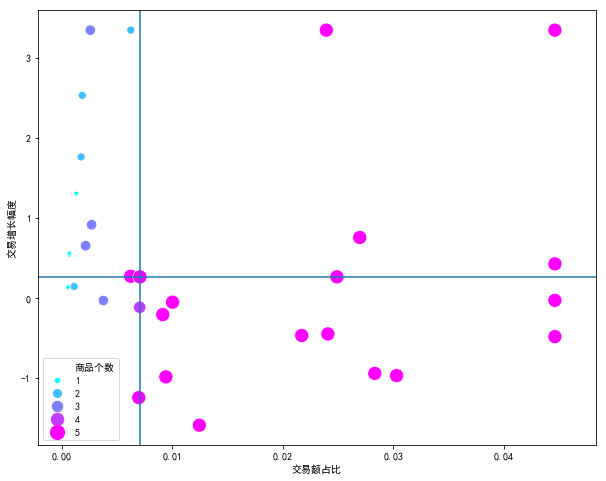

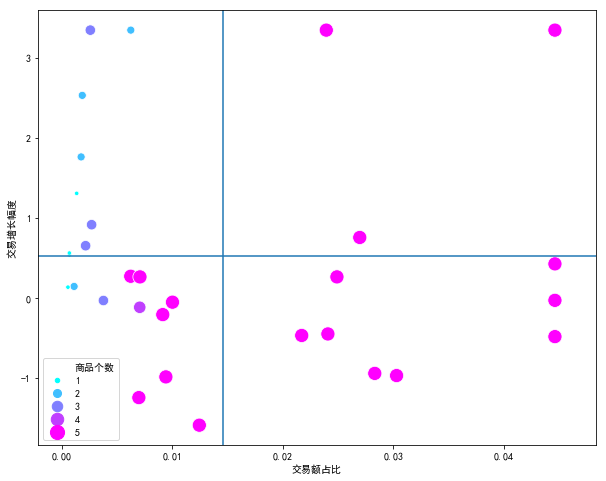

In [239]:
plot_BCG(klck_plot)
plot_BCG(klck_plot,plot_m=True)

In [240]:
klckstar,klckcow,klckque,klckdog = get_BCG_data(klck_goods_data)
klckstar1,klckcow1,klckque1,klckdog1 = get_BCG_data(klck_goods_data,by='交易增长幅度')

- 科凌虫控明星产品

In [241]:
klckstar

,交易增长幅度,交易金额,交易额占比,商品个数
商品,,,,
除螨虫家用喷剂床上祛防螨去螨虫神器喷雾剂包贴杀虫剂免洗非杀菌,4.0371,2270518.54,0.048815,5
老鼠贴超强力粘鼠板灭鼠神器捕鼠魔毯yao颗粒老鼠胶家用药捕鼠器,0.4288,2074886.77,0.044609,5
科凌虫控蟑螂药屋蟑螂克星杀蟑胶饵灭蟑螂粉全窝端家用强力灭蟑清,0.7592,1253677.00,0.026953,5
蟑螂屋强力灭蟑清蟑螂贴家用无毒粉杀蟑螂药胶饵捕捉器克星全窝端,0.2660,1157585.18,0.024888,5
去儿童头虱除阴虱净喷剂百部酊虱卵用虱子药成人一扫光净虱灵喷雾,3.3529,1112790.54,0.023924,5
绿叶老鼠贴强力粘鼠板沾灭鼠神器胶药yao颗粒捕鼠器克星正品家用,0.2659,328698.54,0.007067,5


- 主要是灭鼠,除螨和杀虫

- 科凌虫控奶牛产品

In [242]:
klckcow

,交易增长幅度,交易金额,交易额占比,商品个数
商品,,,,
蟑螂药一窝端蟑螂屋胶饵灭蟑螂无毒厨房家用强力杀蟑螂克星全窝端,-0.4814,21966057.02,0.472259,5
蟑螂屋捕捉器除灭蟑螂药一窝端神器纸盒子胶饵杀小蟑螂贴厨房家用,-0.0274,7464346.74,0.160480,5
杀蟑螂药一窝端蟑螂药粉家用捕捉器屋厨贴无毒灭蟑螂粉除小强克星,-0.9685,1408637.81,0.030285,5
跳蚤杀虫剂家用厕所卫生间下水道除虫灭小飞虫蛾蚋蟑螂臭虫药室内,-0.9412,1316871.08,0.028312,5
粘鼠板超强力驱老鼠贴灭鼠抓老鼠夹药捕鼠器黏老鼠胶沾鼠神器家用,-0.4478,1119499.65,0.024069,5
科凌虫控杀蟑螂药一窝端灭蟑螂胶饵药粉克星南方大蟑螂全窝端家用,-0.4669,1009419.11,0.021702,5
米面蛾诱捕器蛾子粘捕器家用小飞虫杀虫剂灭飞蛾除米蛾衣蛾蚋蛾蠓,-1.5892,578549.20,0.012439,5
老鼠笼捕鼠器全自动超强家用抓老鼠夹药捉耗子连续灭鼠神器驱鼠器,-0.0504,465621.51,0.010011,5
除跳蚤喷剂床上杀虫剂气雾家用潮虫驱虫灭去蚂蚁药神器室内杀蜘蛛,-0.9851,437756.89,0.009412,5


- 主要是除蟑,有很小部分灭虫和灭鼠

- 科凌虫控问题产品

In [243]:
klckque1

,交易增长幅度,交易金额,交易额占比,商品个数
商品,,,,
天然除螨虫包喷雾剂中草药祛防杀去螨虫垫贴床上用品家用驱虫神器,815.9653,290170.09,0.006239,2
抓老鼠贴强力粘鼠板胶药沾灭鼠器捕鼠神器克星家用正品20张一窝端,12.6585,119948.74,0.002579,3
蟑螂药蟑螂克星家用非无毒全窝端室内厨房南方大蟑螂一窝端脏螂药,2.5367,86020.53,0.001849,2
老鼠贴强力粘鼠板正品一窝端灭鼠器老鼠克星胶yao颗粒家用10片装,1.7667,81123.80,0.001744,2
老鼠笼捕鼠器家用一窝端连续全自动强力扑捉抓灭老鼠夹子捕鼠神器,1.3110,62508.93,0.001344,1
蟑螂药粉德国小蠊小强专杀灭蟑螂屋纸盒子家用蟑螂克星全窝端厨房,0.9189,125300.73,0.002694,3
科凌虫控老鼠贴超强力粘鼠板日本版捉抓老鼠夹胶家用灭鼠药捕鼠器,0.6561,99998.35,0.002150,3
跳蚤杀虫剂家用气雾剂除螨虫喷雾潮虫百虫灵蜈蚣蟑螂药灭蚂蚁虱子,0.5642,31783.47,0.000683,1
科凌虫控蟑螂药南方大蟑螂强力杀蟑饵剂蟑螂胶饵家用全窝端灭蟑清,0.5414,32057.62,0.000689,1


- 有较大潜力的是除螨

- 总结:科凌虫控积极发展多个产品,然而每个产品结构相对独立(奶牛除蟑,明星灭鼠,潜力除螨),没有后续的支持.竞争力不是那么强

## 流量结构分析

In [249]:
os.chdir('..')  #返回上一级目录，若需要返回前两级目录，此命令执行两次
os.getcwd()

'E:\\Data analysis\\CDA\\learning\\0、python自己练习\\7、项目实战\\data\\电商文本\\竞争数据'

In [250]:
os.chdir(r'.\流量渠道数据')    #定位文件所在位置

In [258]:
traffic_data=pd.DataFrame()
for fname in os.listdir():   
    if re.search(r'\.xlsx$',fname):
        col_name=re.match('(.*?)旗舰店',fname).groups()[0]
        col_name=col_name.replace('家居','')
        col_name=col_name.replace('官方','')
        # 读取数据
        df=pd.read_excel(fname) 
        df['品牌']=col_name
        traffic_data=pd.concat((traffic_data,df),ignore_index=True)

D:\tool\anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


In [293]:
traffic_data.head()

,交易指数,交易指数.1,品牌,流量来源
0,119751,NaN,安速,淘内免费
1,86389,NaN,安速,手淘搜索
2,62653,NaN,安速,淘内免费其他
3,31348,NaN,安速,手淘问大家
4,25514,NaN,安速,手淘旺信


- 定义流量结构分析函数

In [419]:
def flow_analysis(df,brand_name,top_n=10):
    """
    df:一个数据框
    brand_name：品牌名称
    top_n：排名数值
    """
    flow_data=df[df['品牌']==brand_name][['交易指数','流量来源']].copy()
    flow_data=flow_data.groupby(by='流量来源').sum()
    flow_data.sort_values(by='交易指数',ascending=False,inplace=True)
    topN=flow_data.iloc[:top_n,:].copy()
    topN['交易指数占比']=topN['交易指数']/topN['交易指数'].sum()
    #定位付费流量
    paid=['付费流量','直通车','淘宝联盟','淘宝客','手淘问大家']
    ind=topN.index.isin(paid) 
    #突出显示付费流量项目数据
    explode=ind*0.1
    ax=topN['交易指数占比'].plot.pie(autopct='%.1f%%',explode=explode,figsize=(8,8),cmap='cool')
    ax.set_ylabel('')
    plt.show()
    #打印数据
    salesum=topN['交易指数'].sum()
    paidsum=topN.loc[ind,:]['交易指数占比'].sum()
    paidsale=topN.loc[ind,:]['交易指数'].sum()
    print("前10流量中：总交易指数：{0};付费流量占比：{1};付费流量带来交易指数:{2}".format(
    salesum,'%.2f%%'%(paidsum*100),paidsale))
    return topN

### 拜耳

- 只取交易指数排名前10的流量渠道分析

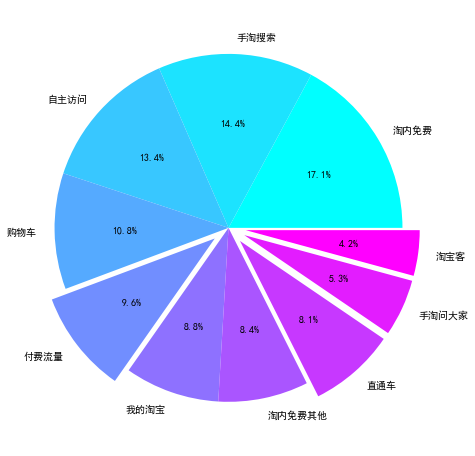

前10流量中：总交易指数：2334051;付费流量占比：27.14%;付费流量带来交易指数:633471


In [420]:
baier_top10=flow_analysis(traffic_data,'拜耳')

- 排名前10的详细数据

In [421]:
baier_top10

,交易指数,交易指数占比
流量来源,,
淘内免费,399466,0.171147
手淘搜索,336457,0.144152
自主访问,312587,0.133925
购物车,251600,0.107795
付费流量,223315,0.095677
我的淘宝,205162,0.087900
淘内免费其他,195308,0.083678
直通车,187952,0.080526
手淘问大家,123512,0.052917


### 安速

- 只取交易指数排名前10的流量渠道分析

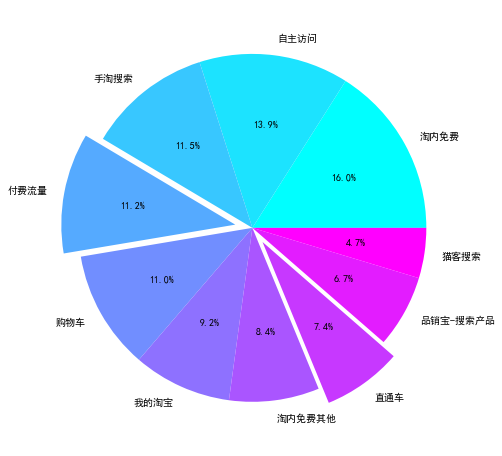

前10流量中：总交易指数：748539;付费流量占比：18.58%;付费流量带来交易指数:139048


In [422]:
ansu_top10=flow_analysis(traffic_data,'安速')

- 可见拜耳和安速的流量配比是差不多的,安速的整体流量小很多,即流量效果拜耳明显优于安速

### 科凌虫控

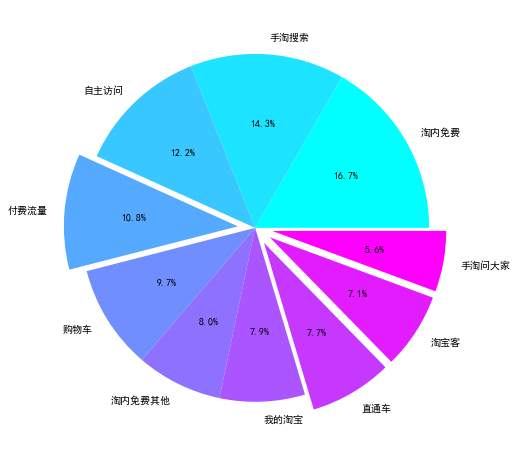

前10流量中：总交易指数：1918111;付费流量占比：31.14%;付费流量带来交易指数:597371


In [424]:
klck_top10=flow_analysis(traffic_data,'科凌虫控')

- 和拜耳在流量上差不多,科凌虫控付费占比较高

# 舆情分析

## 分析思路

- 文本数据的分析过程：
  -  清洗基本流程：
      - 中文文本：
        - 替换非中英文字符为空格
        - 分词(结巴jieba)
        - 去掉停用词(对描述和建模无意义的词)
        - 筛选高频词
      - 英文文本：
        - 剪枝文本
        - 去掉停用词(对描述和建模无意义的词)
        - 筛选高频词
        - 英文文本处理好用的库[shorttext](https://shorttext.readthedocs.io/en/latest/tutorial.html)
      - 无论中文文本还是英文文本，此流程需要反复尝试对比效果
  - 可视化：
    - 一般都是词云,可能配合关键词排序等
  - 建模：
    - 建模前需要将数据转成文档词矩阵(dtm)
    - 有监督和无监督的流程不同：
        - 有监督的话常用的是贝叶斯,其他偏精度的算法也可以,要注意特征个数
        - 无监督常用的是主题模型LDA,其他诸如分群,情感分析也可以
- 注：清洗流程中,尤其是口语化较强的数据,例如评论数据,需要去除重复语句,以及字数少于某个阈值的评论.

## 读取数据

In [425]:
os.chdir('..')  #返回上一级目录，若需要返回前两级目录，此命令执行两次
os.getcwd()

'E:\\Data analysis\\CDA\\learning\\0、python自己练习\\7、项目实战\\data\\电商文本\\竞争数据'

In [426]:
os.chdir(r'.\评论舆情数据')   #定位文件所在位置

In [430]:
opinion_data=pd.DataFrame()
for fname in os.listdir():   
    if re.search(r'\.xlsx$',fname):
        col_name=fname.split('.')[0]
        col_name=col_name.replace('德国','')
        # 读取数据
        df=pd.read_excel(fname,date_parser='评论日期') 
        df['品牌']=col_name
        opinion_data=pd.concat((opinion_data,df),ignore_index=True)

In [431]:
opinion_data.head()

,产品名称,链接,评论页码,评论,评论日期,品牌
0,日本安速小强恢恢蟑螂屋纸盒子捕捉器药灭杀强力家用贴克星全窝端,https://detail.tmall.com/item.htm?spm=a230r.1....,0,此用户没有填写评论!,2018-11-18 12:19:09,安速
1,日本安速小强恢恢蟑螂屋纸盒子捕捉器药灭杀强力家用贴克星全窝端,https://detail.tmall.com/item.htm?spm=a230r.1....,0,此用户没有填写评论!,2018-11-22 13:51:39,安速
2,日本安速小强恢恢蟑螂屋纸盒子捕捉器药灭杀强力家用贴克星全窝端,https://detail.tmall.com/item.htm?spm=a230r.1....,0,真没想到家里竟有这么多，昨晚上放的，今天早起都还在动，沙发底下，床底下，厨房几乎都是十几二十...,2018-11-23 13:57:18,安速
3,日本安速小强恢恢蟑螂屋纸盒子捕捉器药灭杀强力家用贴克星全窝端,https://detail.tmall.com/item.htm?spm=a230r.1....,0,效果还不错，每个盒子里都有蟑螂，感觉还不错，之前买过别的牌子，蟑螂都不怎么往里进，这次比以前...,2018-11-22 15:37:16,安速
4,日本安速小强恢恢蟑螂屋纸盒子捕捉器药灭杀强力家用贴克星全窝端,https://detail.tmall.com/item.htm?spm=a230r.1....,0,物流速度快，蟑螂基本上没有了，以前天天看到蟑螂到处爬，放了一个礼拜效果不错，放上去蟑螂自己就...,2018-11-24 12:02:57,安速


- 构建停用词列表

In [440]:
# 我们使用百度停用词数据
stopwords=pd.read_csv('百度停用词表.txt',names=['stopwords'])
stopwords.loc[stopwords.shape[0],'stopwords']=' '  #把空格符合也纳入

- 定义文本分析函数

In [503]:
def words_analysis(series,stopword):
    """
    函数说明:
        通过一个文本Series对象及停用词Series对象，
        获取分词数据及词频数据
        
    参数说明：
        series：一个Series列表，待处理文本数据
        stopword：一个Series对象，停用词数据
    输出：
        输出词云列表、词频序列
    """
    # 先去掉非中英文字符
    op_dt=series.apply(lambda x:re.sub(r'[^a-z\u4E00-\u9Fa5]+',' ',x,flags=re.I))
    #re.sub():用新字符替换符合正则规则的字符串
    #\u4E00-\u9Fa5:表示中文字符
    #re.I:表示不区分大小写英文字符
    
    # 获取分词
    temp_words=[]
    for per_op in op_dt:
        # 使用标准模式获取词语
        seg0=pd.Series(jieba.lcut(per_op))
        # 筛掉长度等于1的词
        ind1=seg0.map(lambda x:True if len(x)>1 else False)
        seg1=seg0[ind1]
        # 去掉停用词，去重
        ind2=~seg1.isin(stopword)
        seg2=list(seg1[ind2].unique())
        # 去掉筛选后的空列表
        if len(seg2)>0:
            temp_words.append(seg2)
    # 组合多个列表到一个列表
    part_words=[y for x in temp_words for y in x]
    
    # 计算词频
    words_freq=pd.Series(part_words).value_counts()
    
    return part_words,words_freq

- 定义绘制词云图函数

In [515]:
def plot_wordcloud(strdata,impath,isCH=True,c_font='simkai',bg_color='wheat'):
    """
    函数说明:
        通过一个文本字符及画出词云图
        
    参数说明：
        strdata：一个分词字符串
        impath:背景图片文件路径
        isCH：是否中文文本，默认True        
        font:中文文本需要设置字体，默认simkai
        bg_color:图形背景颜色
    输出：
        输出词云图,并返回词云图数据
    """    
    import imageio
    from wordcloud import WordCloud
    
    #获取背景图片
    mask=imageio.imread(impath)
    
    # 中文文本和英文文本不一样制图
    if isCH:
        font=r'C:\Windows\Fonts\{}.ttf'.format(c_font)
        wc=WordCloud(background_color=bg_color,mask=mask,
                     font_path=font).generate(strdata)
    else:
        wc=WordCloud(background_color=bg_color,mask=mask).generate(strdata)
    
    plt.figure(figsize=(8,8))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()
    return wc

## 拜耳

- 抽取评论列数据

In [433]:
baier_op=opinion_data[opinion_data['品牌']=='拜耳']['评论']

- 获取词云数据

In [504]:
baier_ops,baier_wdfreq=words_analysis(baier_op,stopwords['stopwords'])

- 绘制词云图

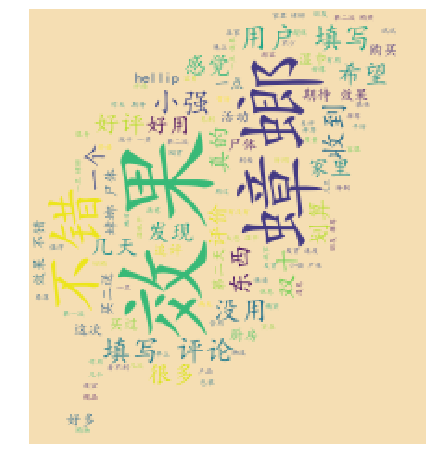

In [516]:
baier_w=' '.join(baier_ops)
impath=r'E:\Data analysis\wordcloud_bgimage\leaf.jpg'

baier_wc=plot_wordcloud(baier_w,impath)

- 导出词云文件

In [517]:
if not os.path.exists('wordcloudpict'):
    os.mkdir('wordcloudpict')
baier_wc.to_file('wordcloudpict\拜耳舆情词云.png')

- 基于 TF-IDF 算法抽取关键词

In [520]:
jieba.analyse.extract_tags(baier_w,20,True)

[('蟑螂', 0.35868827490141125),
 ('效果', 0.2849843733535205),
 ('双十', 0.12792281324949317),
 ('小强', 0.09200132125972145),
 ('评论', 0.08243514073285675),
 ('湿巾', 0.0800848241710357),
 ('填写', 0.07859912763569854),
 ('不错', 0.07854611456578228),
 ('好评', 0.07205703576029969),
 ('追评', 0.06743985193350374),
 ('没用', 0.06355521640160776),
 ('收到', 0.06240940420464874),
 ('用户', 0.06013517913107095),
 ('好用', 0.05909939270004407),
 ('尸体', 0.05479502199496166),
 ('划算', 0.05456206954124107),
 ('湿纸巾', 0.05268657021031292),
 ('家里', 0.04667477953221154),
 ('发货', 0.04579483339359189),
 ('期待', 0.04317101167929661)]

- 不管从词云还是关键词来看,评价偏好评,没有明显问题
- 可以在停用词中添加好评,蟑螂可以再看效果

'E:\\Data analysis\\CDA\\learning\\0、python自己练习\\7、项目实战\\data\\电商文本\\竞争数据\\评论舆情数据'

array([False, False, False, False,  True, False, False,  True,  True,
        True])